# Prepare Data

In [ ]:
import pandas as pd

# Load data
df = pd.read_csv("/Users/willjettinghoff/Desktop/Wise Jugement/Prelim Data/WJC_firstwave_merged_with_original.csv")

# Define prompts
prompts = [
    "1. What was this difficult decision about? Please describe in detail who was involved, where and when it took place, and what was happening at that time.",
    "2. What specific issues did you encounter when making this difficult decision?",
    "3. What were you thinking when you first encountered this difficult decision?",
    "4. What were you feeling when you first encountered this difficult decision?",
    "5. If you are comfortable sharing, what steps did you take to address this difficult decision?",
    "6. In what ways did this difficult decision affect your life?",
    "7. Is there anything else you would like to share about this difficult decision?"
]

# Merge original-language responses
def merge_open_responses_original(df):
    lb = [f'LB_Open_Q{i}_original' for i in range(1, 8)]
    smb = [f'SMB_Open_Q{i}_original' for i in range(1, 8)]
    target = [f'Open_{i}_original' for i in range(1, 8)]

    has_lb = df[lb].notna().any(axis=1)
    df.loc[has_lb, target] = df.loc[has_lb, lb].values
    df.loc[~has_lb, target] = df.loc[~has_lb, smb].values

    df['open_type_original'] = has_lb.map({True: 'LB', False: 'SMB'})
    return df.drop(columns=lb + smb)

# Merge English-translated responses
def merge_open_responses_en(df):
    lb = [f'LB_Open_Q{i}' for i in range(1, 8)]
    smb = [f'SMB_Open_Q{i}' for i in range(1, 8)]
    target = [f'Open_{i}_en' for i in range(1, 8)]

    has_lb = df[lb].notna().any(axis=1)
    df.loc[has_lb, target] = df.loc[has_lb, lb].values
    df.loc[~has_lb, target] = df.loc[~has_lb, smb].values

    df['open_type_en'] = has_lb.map({True: 'LB', False: 'SMB'})
    return df.drop(columns=lb + smb)

# Concatenate prompt + response strings
def concatenate_open_responses(df, prefix):
    response_cols = [f'Open_{i}_{prefix}' for i in range(1, 8)]

    # Full concatenated text
    df[f'all_open_{prefix}'] = (
        prompts[0] + " " + df[response_cols[0]].fillna('No response.') + " " +
        prompts[1] + " " + df[response_cols[1]].fillna('No response.') + " " +
        prompts[2] + " " + df[response_cols[2]].fillna('No response.') + " " +
        prompts[3] + " " + df[response_cols[3]].fillna('No response.') + " " +
        prompts[4] + " " + df[response_cols[4]].fillna('No response.') + " " +
        prompts[5] + " " + df[response_cols[5]].fillna('No response.') + " " +
        prompts[6] + " " + df[response_cols[6]].fillna('No response.')
    ).str.replace(r'\s+', ' ', regex=True).str.strip()

    # Q1 + Q2
    df[f'Open_Q1_2_{prefix}'] = (
        prompts[0] + " " + df[response_cols[0]].fillna('No response.') + " " +
        prompts[1] + " " + df[response_cols[1]].fillna('No response.')
    ).str.replace(r'\s+', ' ', regex=True).str.strip()

    return df

# Execute full pipeline
df = (
    df
    .pipe(merge_open_responses_original)
    .pipe(merge_open_responses_en)
    .loc[lambda d: d[[f'Open_{i}_original' for i in range(1, 8)]].notna().any(axis=1)]
    .reset_index(drop=True)
)

df = concatenate_open_responses(df, prefix='original')
df = concatenate_open_responses(df, prefix='en')

import re

pattern = re.compile(r'xmlspacepreserve', flags=re.I)   # case-insensitive

def scrub(token):
    if isinstance(token, str):
        return pattern.sub('', token).strip()
    return token

# apply to every string column in the DataFrame
for col, dtype in df.dtypes.items():
    if dtype == 'object':
        df[col] = df[col].apply(scrub)


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 89 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Language               1806 non-null   object 
 1   StartDate              1806 non-null   object 
 2   EndDate                1806 non-null   object 
 3   IPAddress              1806 non-null   object 
 4   Progress               1806 non-null   int64  
 5   Duration..in.seconds.  1806 non-null   int64  
 6   Finished               1806 non-null   bool   
 7   RecordedDate           1806 non-null   object 
 8   ResponseId             1806 non-null   object 
 9   RecipientLastName      158 non-null    object 
 10  RecipientFirstName     158 non-null    object 
 11  RecipientEmail         158 non-null    object 
 12  ExternalReference      158 non-null    object 
 13  LocationLatitude       1806 non-null   object 
 14  LocationLongitude      1806 non-null   object 
 15  Dist

In [2]:
# ===== Text Variables =====
### Normative Question
# Norm_Q
### Lifetime Questions
# LB_Open_Q1
# LB_Open_Q2
# LB_Open_Q3
# LB_Open_Q4
# LB_Open_Q5
# LB_Open_Q6
# LB_Open_Q7
### Last Six Months Questions
# SMB_Open_Q1
# SMB_Open_Q2
# SMB_Open_Q3
# SMB_Open_Q4
# SMB_Open_Q5
# SMB_Open_Q6
# SMB_Open_Q7

### Merged Lifetime & Six Months (use these)
# Open_1
# Open_2
# Open_3
# Open_4
# Open_5
# Open_6
# Open_7
### Merged Responses
# all_open : all open ended responses concatenated
# Open_Q1_2 : open-ended questions 1 & 2 concatenated
# Open_Q3_4 : open-ended questions 3 & 4 concatenated

# Sentiment Analysis

In [ ]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from torch.nn.functional import softmax
from scipy.special import logit

# ──────────── Configuration ────────────

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

MODEL_NAME = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
config    = AutoConfig.from_pretrained(MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)
model.eval()

labels = [config.id2label[i].lower() for i in sorted(config.id2label)]
EPSILON = 1e-6

target_columns = [
    "Norm_Q_original",
    "Open_1_original",
    "Open_2_original",
    "Open_3_original",
    "Open_4_original",
    "Open_5_original",
    "Open_6_original",
    "Open_7_original"
]

# ──────────── Sentiment Scoring Functions ────────────

def get_sentiment_scores(text: str) -> dict:
    if not isinstance(text, str) or text.strip() == "":
        return {f"{label}_score": np.nan for label in labels}

    inputs = tokenizer(
        text, max_length=512, truncation=True, return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        logits = model(**inputs).logits
        probs = softmax(logits, dim=1).squeeze().cpu().tolist()

    return {f"{label}_score": prob for label, prob in zip(labels, probs)}

def compute_sentiment_dataframe(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    results = []

    for col in tqdm(columns, desc="Scoring sentiment"):
        score_dicts = df[col].apply(get_sentiment_scores)
        scores_df = pd.DataFrame(score_dicts.tolist())
        scores_df.columns = [f"{c}_{col}" for c in scores_df.columns]
        results.append(scores_df)

    return pd.concat(results, axis=1)

def apply_logit_scaling(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    for col in columns:
        # Coerce to numeric, invalid parsing (e.g., lists) become NaN
        numeric_col = pd.to_numeric(df[col], errors='coerce')
        clipped = numeric_col.clip(lower=EPSILON, upper=1 - EPSILON)
        df[f"{col}_scaled"] = clipped.apply(lambda x: np.nan if pd.isna(x) else logit(x))
    return df


# ──────────── Run Full Pipeline ────────────

# Assumes df is already defined and contains the target_columns
sentiment_df = compute_sentiment_dataframe(df, target_columns)
df = pd.concat([df.reset_index(drop=True), sentiment_df.reset_index(drop=True)], axis=1)

# Identify newly created score columns for scaling
sentiment_score_cols = [col for col in df.columns if any(col.startswith(prefix) for prefix in ["negative_score_", "neutral_score_", "positive_score_"]) and any(tcol in col for tcol in target_columns)]
df = apply_logit_scaling(df, sentiment_score_cols)

# ──────────── Visualization ────────────

sentiment_categories = ['negative', 'neutral', 'positive']


Scoring sentiment: 100%|██████████| 8/8 [04:45<00:00, 35.73s/it]


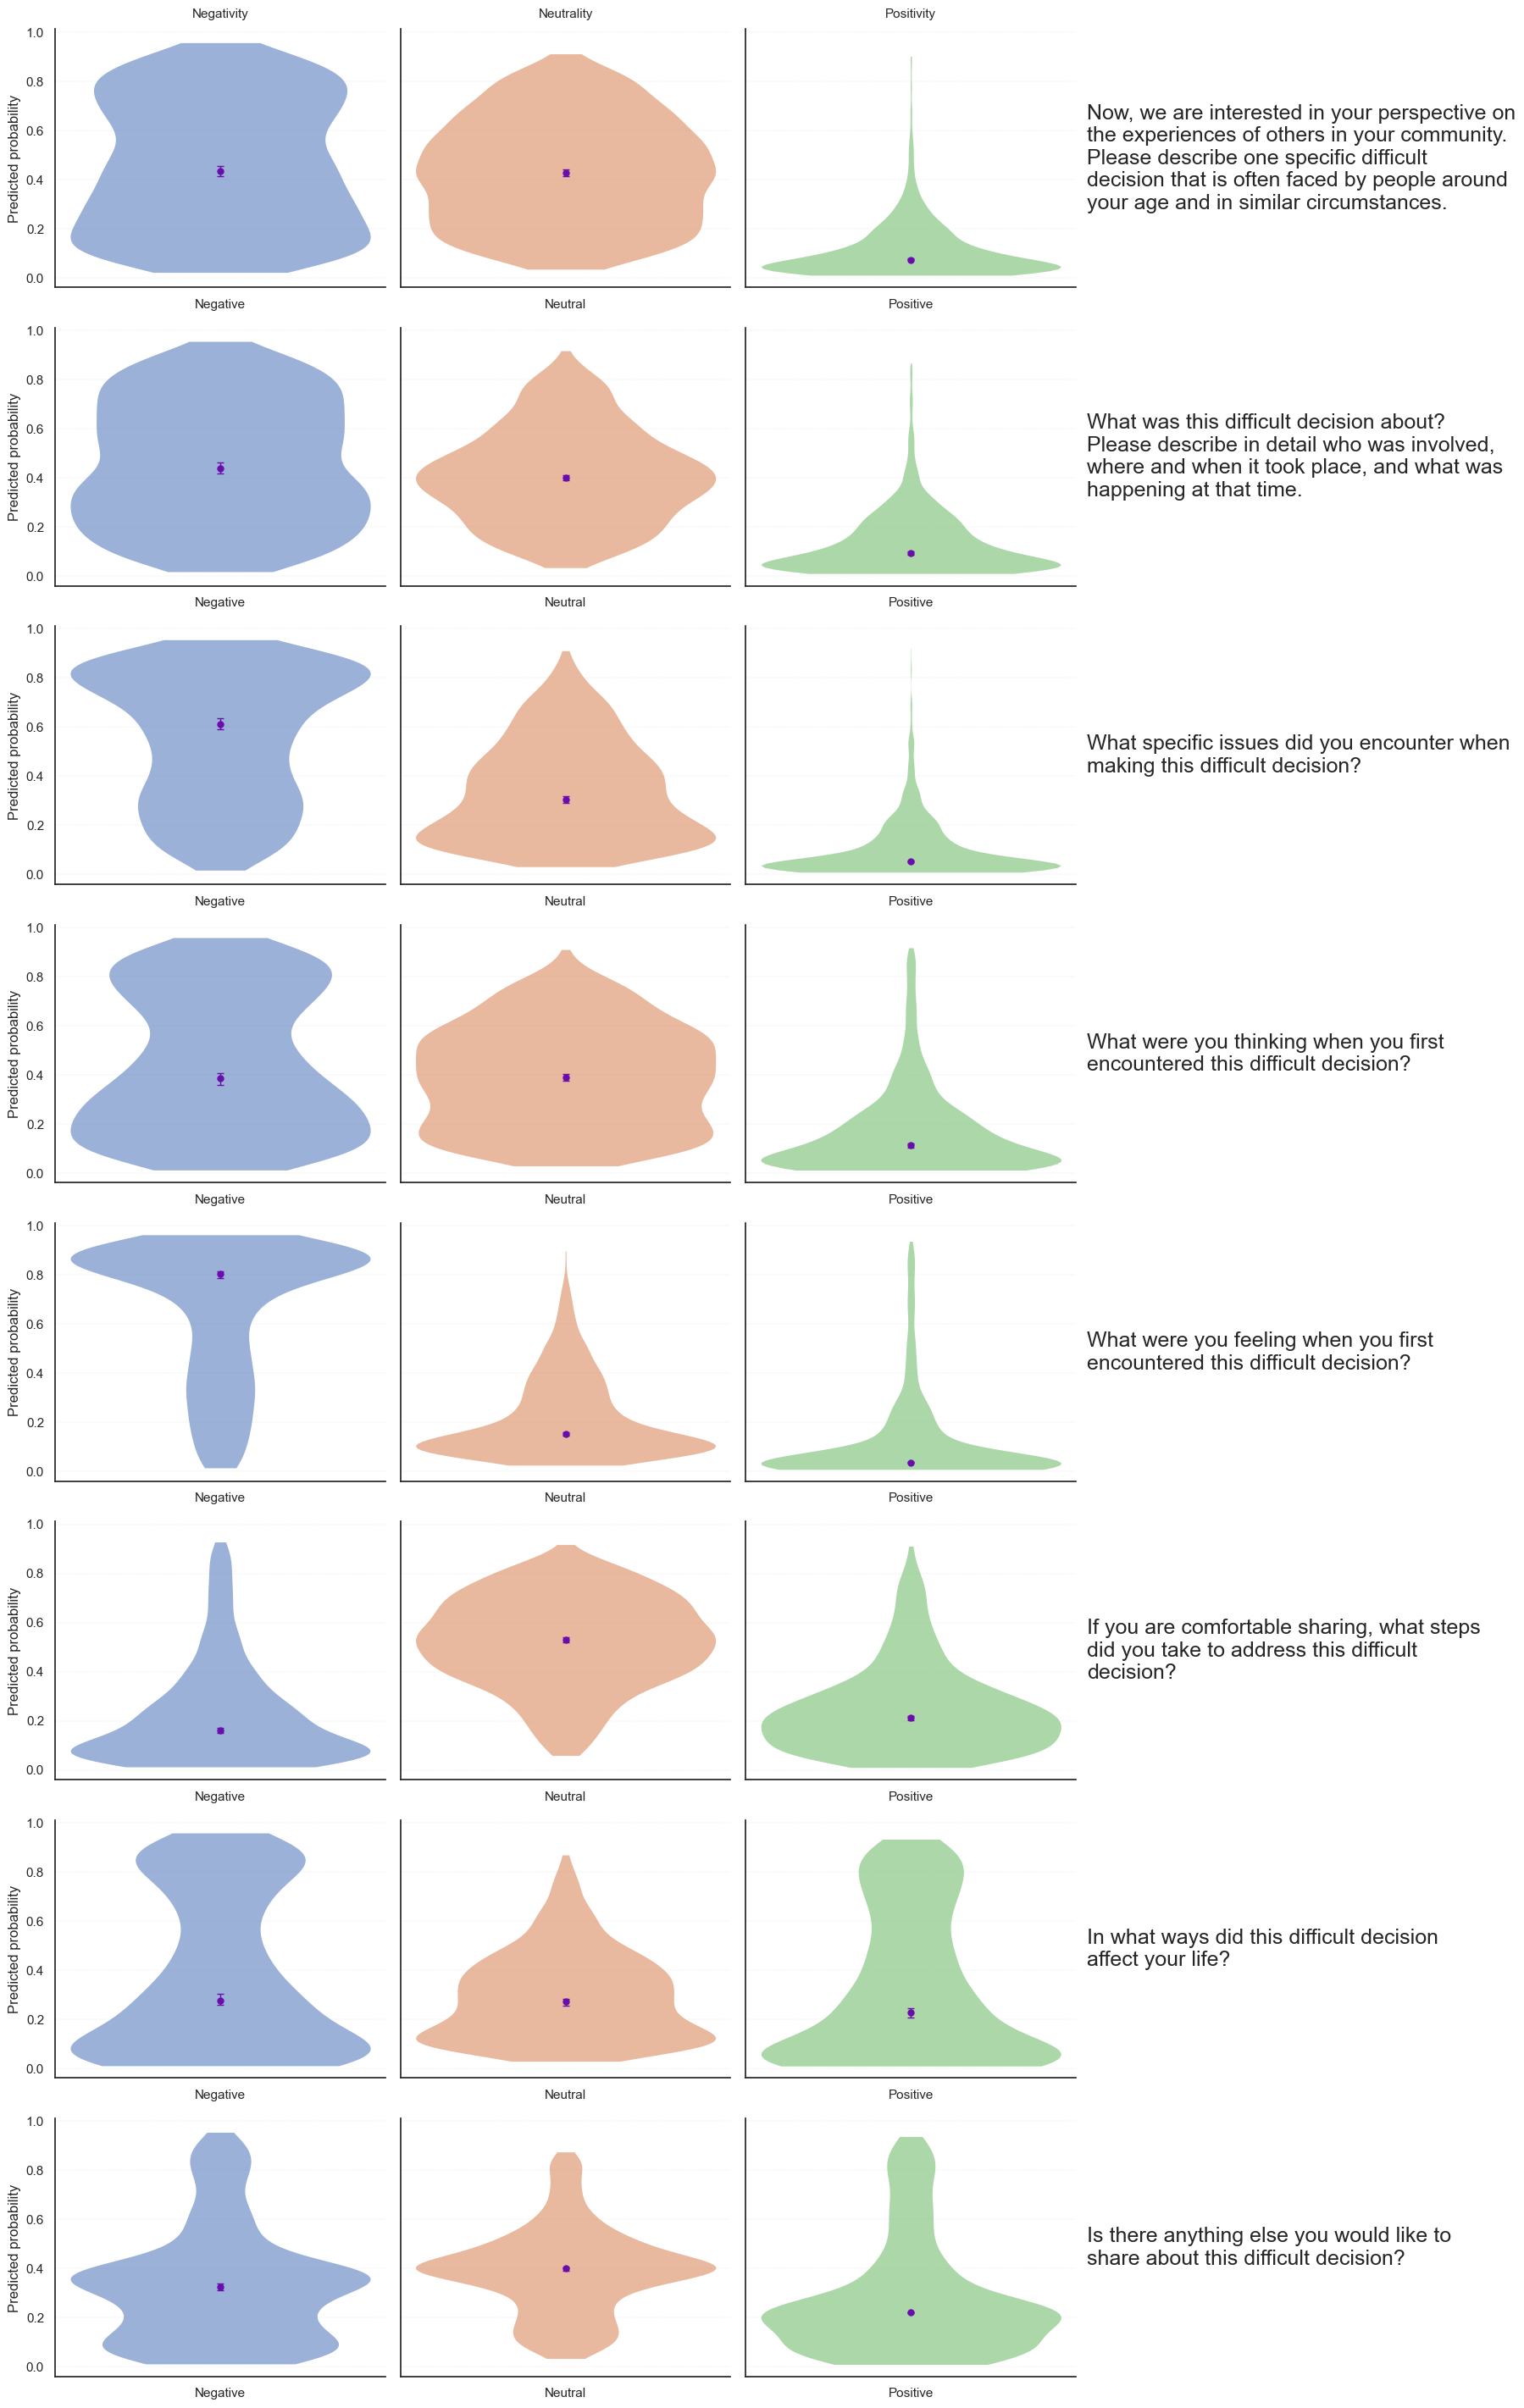

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

# ── Label mappings ─────────────────────────────────────────────────────────
question_labels = {
    "Norm_Q_original": "Q1",
    "Open_1_original": "Q2",
    "Open_2_original": "Q3",
    "Open_3_original": "Q4",
    "Open_4_original": "Q5",
    "Open_5_original": "Q6",
    "Open_6_original": "Q7",
    "Open_7_original": "Q8"
}

question_texts = {
    "Q1": "Now, we are interested in your perspective on the experiences of others in your community. Please describe one specific difficult decision that is often faced by people around your age and in similar circumstances.",
    "Q2": "What was this difficult decision about? Please describe in detail who was involved, where and when it took place, and what was happening at that time.",
    "Q3": "What specific issues did you encounter when making this difficult decision?",
    "Q4": "What were you thinking when you first encountered this difficult decision?",
    "Q5": "What were you feeling when you first encountered this difficult decision?",
    "Q6": "If you are comfortable sharing, what steps did you take to address this difficult decision?",
    "Q7": "In what ways did this difficult decision affect your life?",
    "Q8": "Is there anything else you would like to share about this difficult decision?"
}

sentiment_labels = {
    "Negative": "Negativity",
    "Neutral": "Neutrality",
    "Positive": "Positivity"
}

sentiment_categories = ["negative", "neutral", "positive"]
target_columns = [
    "Norm_Q_original",
    "Open_1_original",
    "Open_2_original",
    "Open_3_original",
    "Open_4_original",
    "Open_5_original",
    "Open_6_original",
    "Open_7_original"
]

# ── Theme settings ─────────────────────────────────────────────────────────
sns.set_theme(style="white", rc={
    "axes.spines.right": False,
    "axes.spines.top": False
})

# ── Reshape sentiment scores for plotting ──────────────────────────────────
long_df_list = []
for qcol in target_columns:
    for sent in sentiment_categories:
        score_col = f"{sent}_score_{qcol}"
        if score_col in df.columns:
            temp = pd.DataFrame({
                "question": qcol,
                "sentiment": sent.capitalize(),
                "prob": df[score_col],
                "Country": df["Country"]  # propagate Country
            })
            long_df_list.append(temp)
long_df = pd.concat(long_df_list, ignore_index=True)
long_df = long_df.dropna(subset=["prob"])

# ── Mapping labels ─────────────────────────────────────────────────────────
long_df["QLabel"] = long_df["question"].map(question_labels)
long_df["SentimentLabel"] = long_df["sentiment"].map(sentiment_labels)

# ── Plot base: violin grid ─────────────────────────────────────────────────
g = sns.catplot(
    data=long_df,
    x="sentiment", y="prob",
    col="SentimentLabel", row="QLabel",
    kind="violin",
    bw=0.25, cut=0, inner=None, linewidth=0,
    height=3.6, aspect=1.2,
    sharex=False, sharey=True,
    palette="muted"
)

# ── Style axes and headers ─────────────────────────────────────────────────
for ax in g.axes.flatten():
    for coll in ax.collections:
        coll.set_alpha(0.6)
    ax.grid(axis="y", linestyle=":", linewidth=0.3)
    ax.set_title("")

for ax, label in zip(g.axes[0], ["Negativity", "Neutrality", "Positivity"]):
    ax.set_title(label, fontsize=11, pad=10)

# ── Overlay: 95% CI around median ──────────────────────────────────────────
import numpy as np
def _median_with_ci(data, color, **kws):
    y = data["prob"].dropna()
    if len(y) < 2:
        return
    med = np.median(y)
    boot_meds = [np.median(np.random.choice(y, size=len(y), replace=True)) for _ in range(1000)]
    ci_low, ci_upp = np.percentile(boot_meds, [2.5, 97.5])
    yerr = np.array([[med - ci_low], [ci_upp - med]])
    plt.errorbar(
        x=0, y=med,
        yerr=yerr,
        fmt='o',
        color="#6A0DAD",
        elinewidth=1.0,
        capsize=3,
        capthick=1.0,
        markersize=5,
        zorder=5
    )
g.map_dataframe(_median_with_ci)

# ── Add question text column ───────────────────────────────────────────────
wrapped_questions = {k: textwrap.fill(v, width=45) for k, v in question_texts.items()}
fig = g.fig
n_rows = len(g.row_names)

for i, qcode in enumerate(g.row_names):
    ax_last = g.axes[i][-1]
    pos = ax_last.get_position()
    new_ax = fig.add_axes([
        pos.x1 + 0.01,
        pos.y0,
        0.18,
        pos.height
    ])
    new_ax.axis("off")
    new_ax.text(
        0, 0.5,
        wrapped_questions[qcode],
        fontsize=18,
        va="center",
        ha="left"
    )

# ── Final formatting and export ────────────────────────────────────────────
g.set_axis_labels("", "Predicted probability")
plt.savefig("figure1_violin_with_text_column_CI.pdf", dpi=300, bbox_inches="tight")
plt.show()

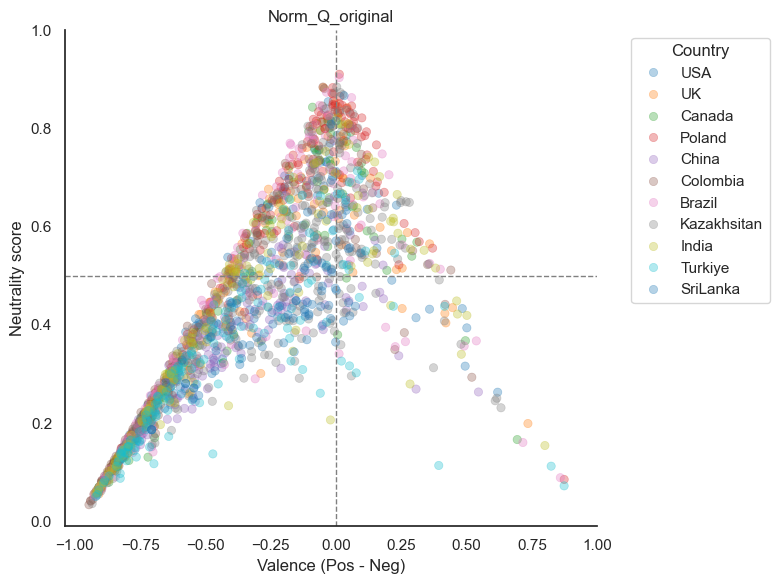

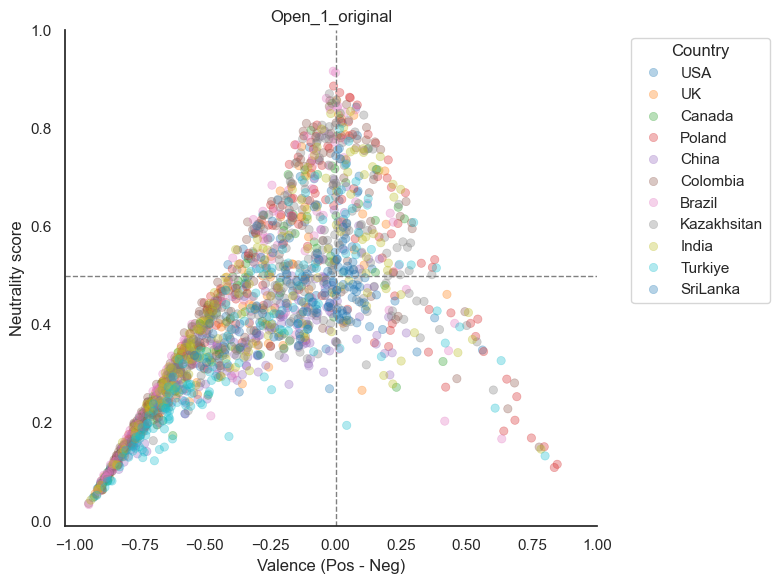

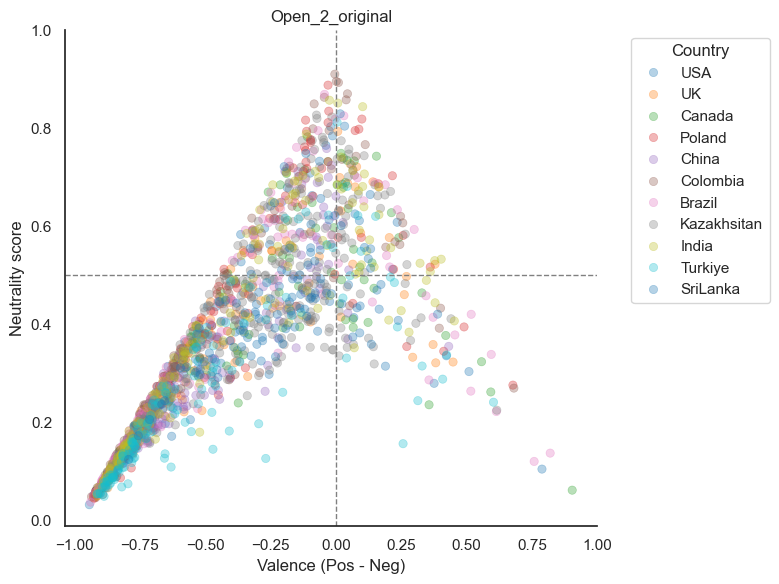

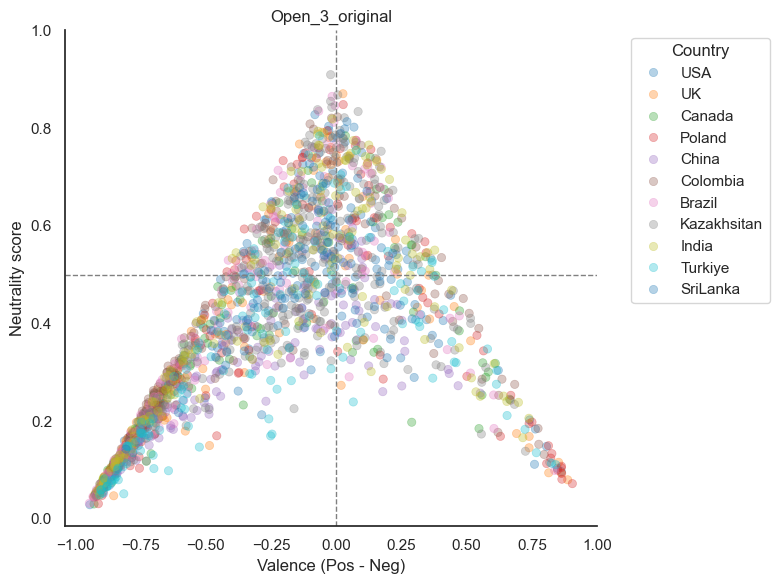

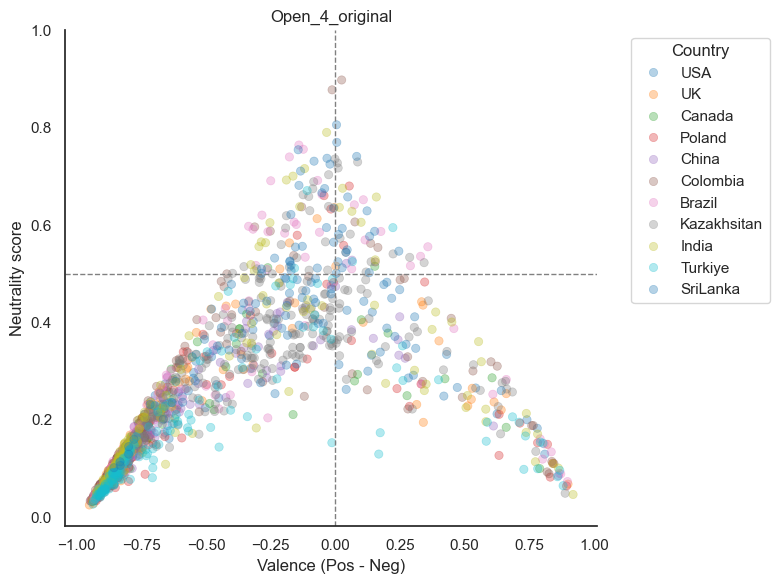

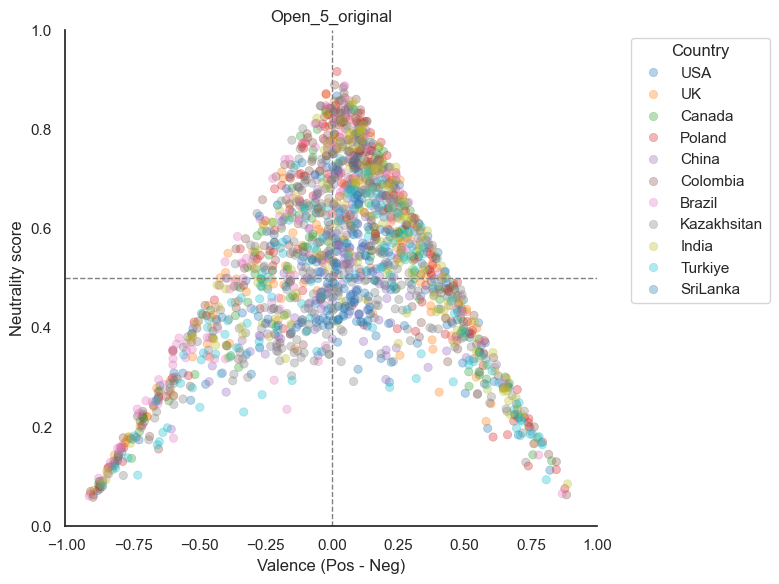

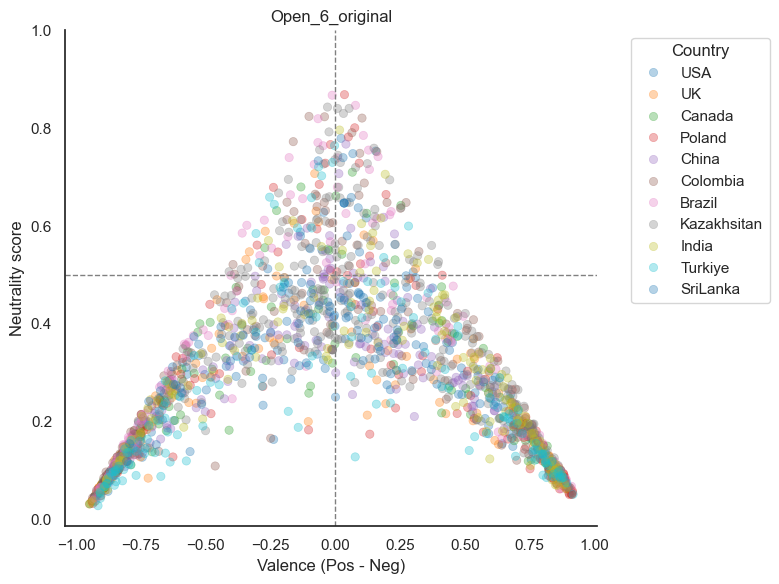

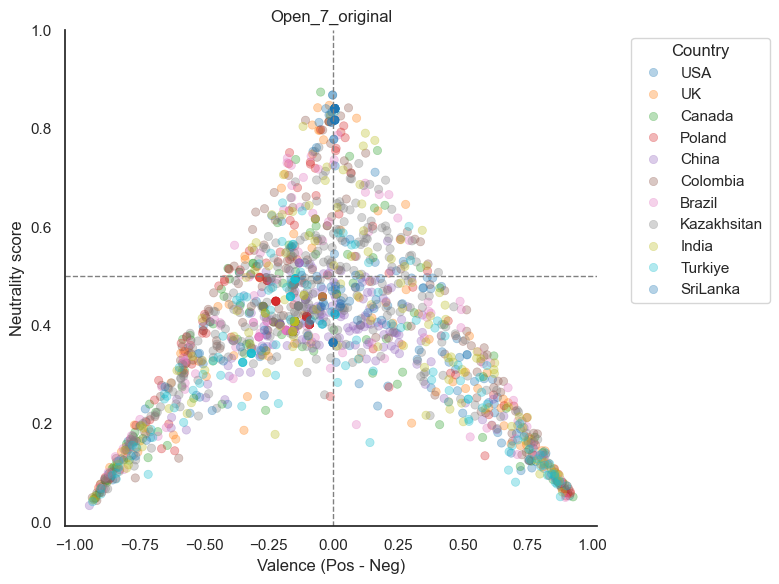

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white", rc={
    "axes.spines.right": False,
    "axes.spines.top": False
})

target_columns = [
    "Norm_Q_original",
    "Open_1_original",
    "Open_2_original",
    "Open_3_original",
    "Open_4_original",
    "Open_5_original",
    "Open_6_original",
    "Open_7_original"
]

for col in target_columns:
    pos = f"positive_score_{col}"
    neg = f"negative_score_{col}"
    neu = f"neutral_score_{col}"
    val_col = f"valence_{col}"

    # Skip if required columns are missing
    if not all(c in df.columns for c in [pos, neg, neu, "Country"]):
        print(f"Skipping {col}: missing required columns.")
        continue

    # Compute valence
    df[val_col] = df[pos] - df[neg]

    # Scatterplot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df,
        x=val_col,
        y=neu,
        hue="Country",
        palette="tab10",
        alpha=0.33,
        edgecolor=None
    )
    plt.axhline(0.5, color="gray", linestyle="--", linewidth=1)
    plt.axvline(0, color="gray", linestyle="--", linewidth=1)
    plt.xlabel("Valence (Pos - Neg)")
    plt.ylabel("Neutrality score")
    plt.title(col)
    # Ensure the full data range is visible, but centered at (0, 0.5)
    xlims = plt.xlim()
    ylims = plt.ylim()
    plt.xlim(min(xlims[0], -1), max(xlims[1], 1))
    plt.ylim(min(ylims[0], 0), max(ylims[1], 1))
    plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()




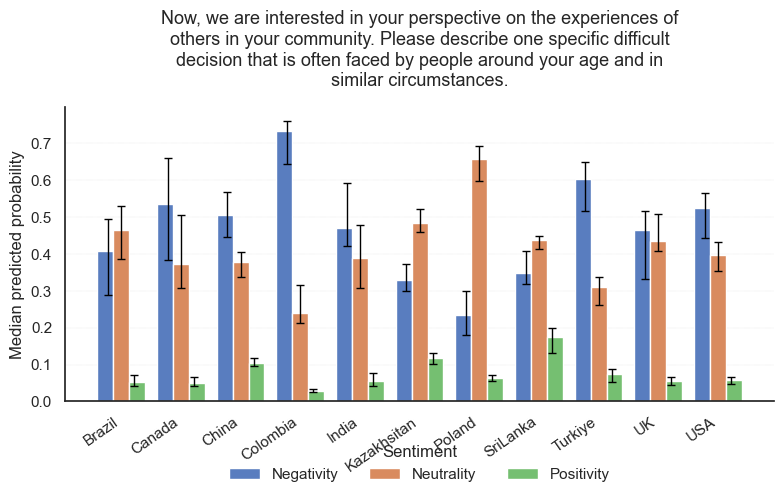

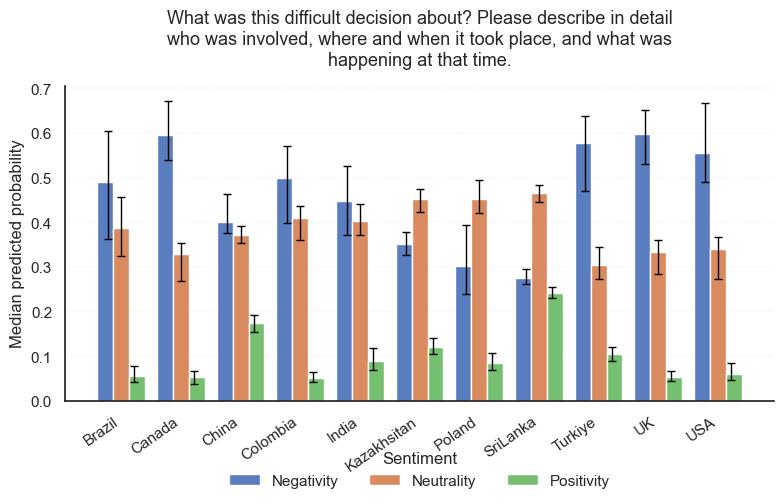

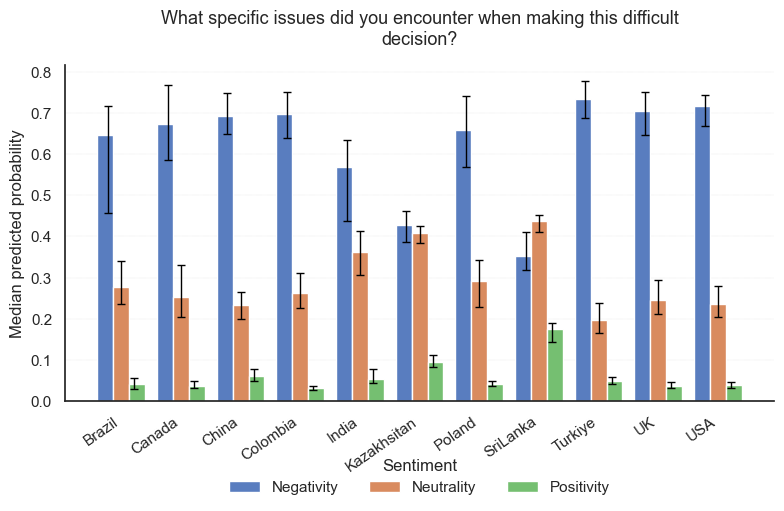

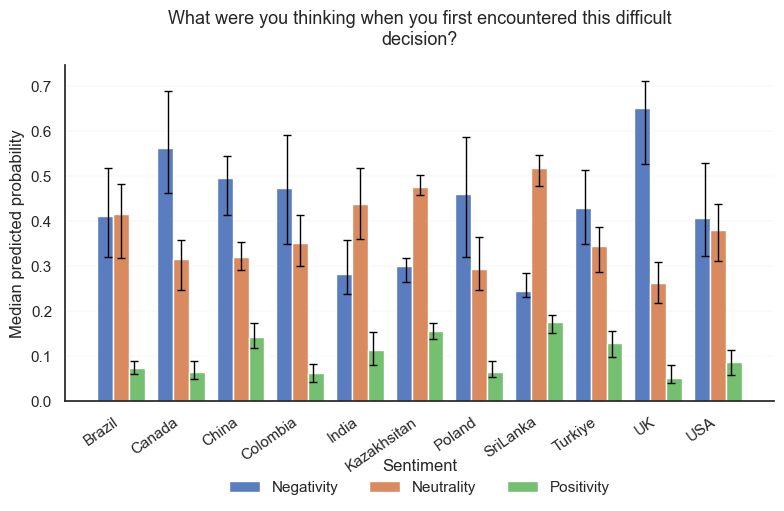

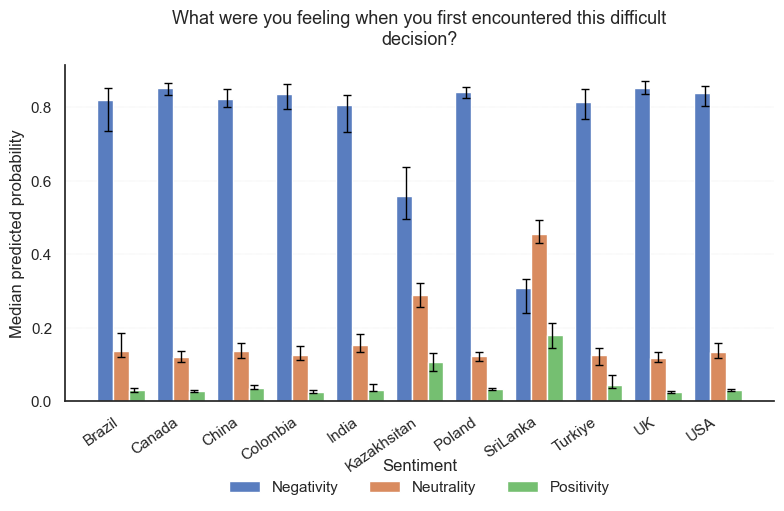

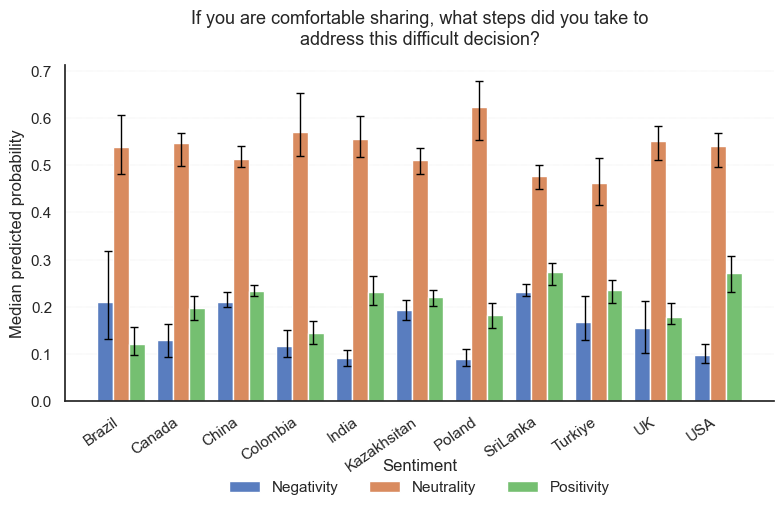

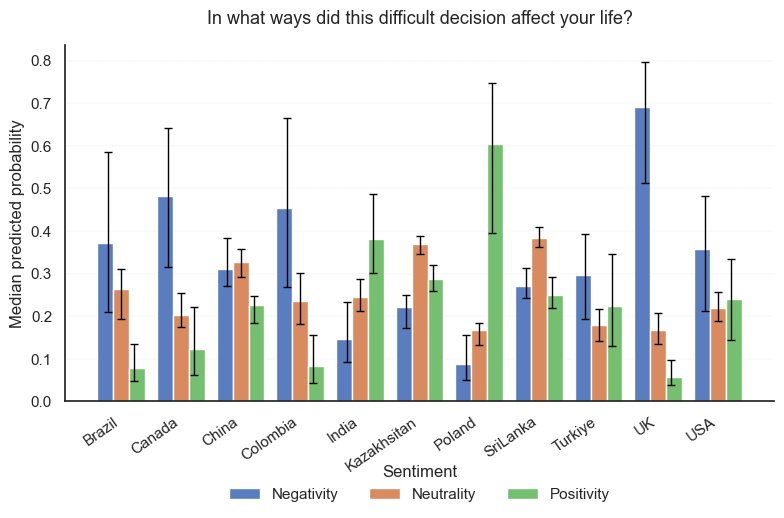

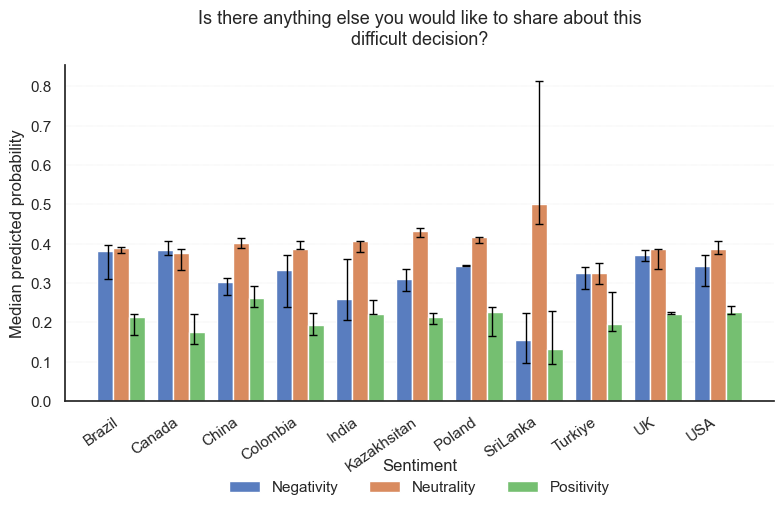

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import numpy as np

sns.set_theme(style="white", rc={
    "axes.spines.right": False,
    "axes.spines.top":  False
})

def bootstrap_median_ci(x, n_boot=1000, alpha=0.05, random_state=None):
    rng = np.random.default_rng(random_state)
    medians = [np.median(rng.choice(x, size=len(x), replace=True)) for _ in range(n_boot)]
    lower = np.percentile(medians, 100 * (alpha / 2))
    upper = np.percentile(medians, 100 * (1 - alpha / 2))
    return np.median(x), lower, upper

target_questions = [
    "Norm_Q_original",   
    "Open_1_original",   
    "Open_2_original",   
    "Open_3_original",   
    "Open_4_original",   
    "Open_5_original",   
    "Open_6_original",
    "Open_7_original",     
]

for qcol in target_questions:
    q_label = question_labels[qcol]
    sent_labels = ["Negativity", "Neutrality", "Positivity"]

    sub_df = (
        long_df
        .loc[lambda d: d["question"] == qcol]
        .assign(
            SentimentLabel=lambda d: d["sentiment"].map(sentiment_labels)
        )
    )

    results = []
    for (country, sent), grp in sub_df.groupby(["Country", "SentimentLabel"]):
        vals = grp["prob"].dropna().values
        if len(vals) == 0:
            continue
        median, ci_lower, ci_upper = bootstrap_median_ci(vals, n_boot=1000, alpha=0.05)
        results.append({
            "Country": country,
            "SentimentLabel": sent,
            "median_prob": median,
            "ci_lower": ci_lower,
            "ci_upper": ci_upper
        })
    agg_df = pd.DataFrame(results)
    country_order = sorted(agg_df["Country"].unique())

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        data=agg_df, x="Country", y="median_prob",
        hue="SentimentLabel", order=country_order, 
        hue_order=sent_labels, palette="muted", ci=None
    )

    # Overlay error bars
    for i, row in agg_df.iterrows():
        x_pos = country_order.index(row["Country"]) + \
                (sent_labels.index(row["SentimentLabel"]) - 1) * 0.22  # bar offset
        ax.errorbar(
            x=x_pos,
            y=row["median_prob"],
            yerr=[[row["median_prob"] - row["ci_lower"]], [row["ci_upper"] - row["median_prob"]]],
            fmt="none", ecolor="black", capsize=3, linewidth=1
        )

    ax.set_title(textwrap.fill(question_texts[q_label], width=65), fontsize=13, pad=15)
    ax.set_ylabel("Median predicted probability")
    ax.set_xlabel("")  # Remove x-axis label
    ax.grid(axis="y", linestyle=":", linewidth=0.3)
    plt.xticks(rotation=35, ha="right")
    plt.tight_layout()

    # Move legend to bottom, make flat
    plt.tight_layout(rect=[0, 0.000001, 1, 1])  # Leaves more space at the bottom (adjust 0.08 as needed)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, labels, title="Sentiment",
        loc="lower center", bbox_to_anchor=(0.5, -0.32),  # Move legend lower; -0.32 is usually safe
        ncol=3, frameon=False
    )


    plt.savefig(f"figure_median_bar_{q_label}.pdf", dpi=300, bbox_inches="tight")
    plt.show()


# Emotion Recognition

In [54]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from torch.nn.functional import sigmoid
from scipy.special import logit

# Configuration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
MODEL_NAME = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME)  # includes id2label mapping
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    problem_type="multi_label_classification"
).to(device)
model.eval()
MAX_TOKENS = 512

# Labels (list of 28 emotion names)
emotion_labels = [config.id2label[i] for i in sorted(config.id2label)]

def get_emotion_scores(text: str) -> dict:
    """
    Compute emotion probabilities for a given text.
    Applies sigmoid to each of the 28 model logits.
    Returns a dict mapping '{emotion}_score' to probability.
    """
    inputs = tokenizer(
        text,
        max_length=MAX_TOKENS,
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        logits = model(**inputs).logits.squeeze().cpu().numpy()
    probs = sigmoid(torch.tensor(logits)).numpy()

    return {
        f"{label}_score": float(probs[idx])
        for idx, label in enumerate(emotion_labels)
    }

def compute_emotions_for_columns(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """
    Apply emotion scoring across specified textual columns.
    Produces one probability column per emotion per input column.
    """
    all_dfs = []
    for col in tqdm(columns, desc="Scoring emotions"):
        score_dicts = [
            get_emotion_scores(text) if isinstance(text, str) else {f"{label}_score": np.nan for label in emotion_labels}
            for text in df[col]
        ]
        col_df = pd.DataFrame(score_dicts).add_suffix(f"_{col}")
        all_dfs.append(col_df)
    return pd.concat(all_dfs, axis=1)

# Example usage assuming `df` with the same set of open-ended text columns
target_columns = [    
    "Norm_Q", 
    "Open_1_en", 
    "Open_4_en",  
    "Open_6_en"
    ]

# Run emotion scoring
emotion_results = compute_emotions_for_columns(df, target_columns)
df = pd.concat([df.reset_index(drop=True), emotion_results.reset_index(drop=True)], axis=1)

# Logit scaling probabilities
EPSILON = 1e-6
score_cols = [c for c in df.columns if c.endswith("_score")]
for col in score_cols:
    clipped = df[col].clip(lower=EPSILON, upper=1 - EPSILON)
    df[f"{col}_scaled"] = logit(clipped)

Scoring emotions: 100%|██████████| 4/4 [01:47<00:00, 26.90s/it]


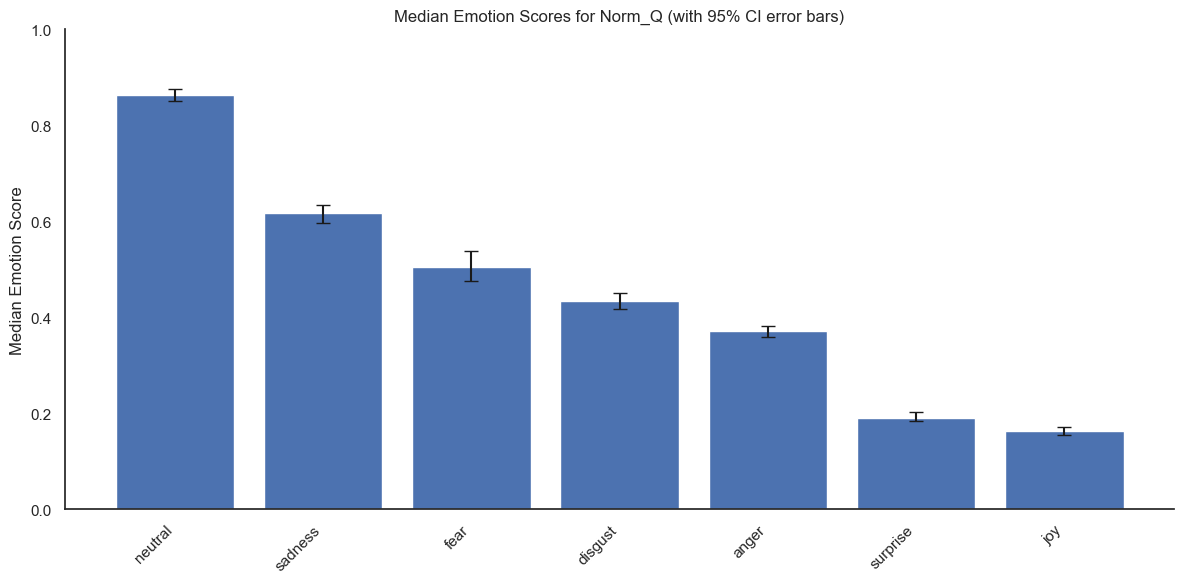

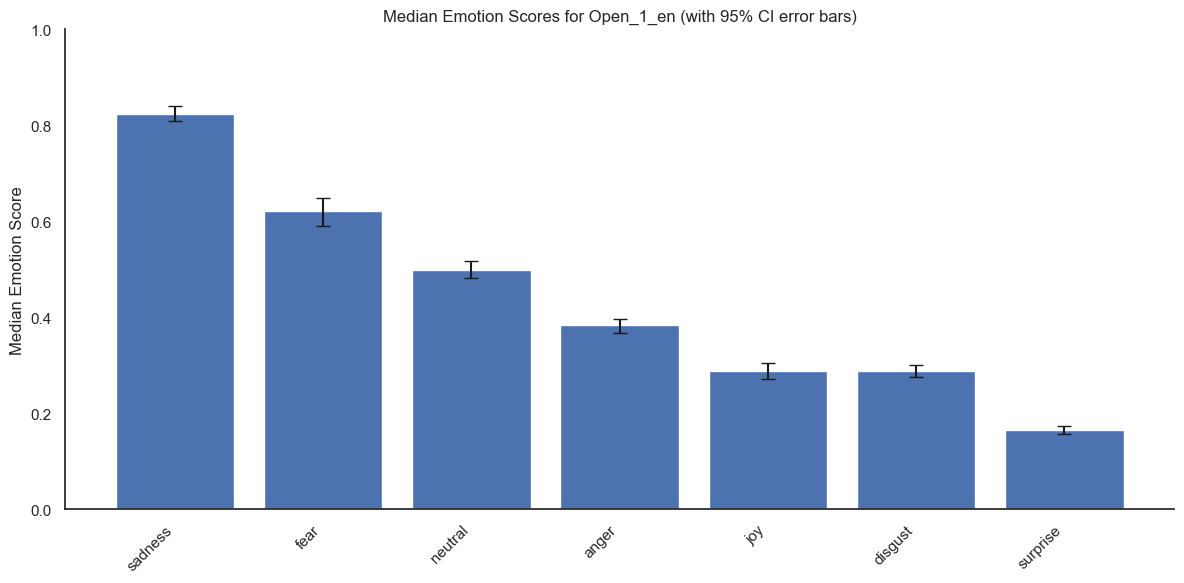

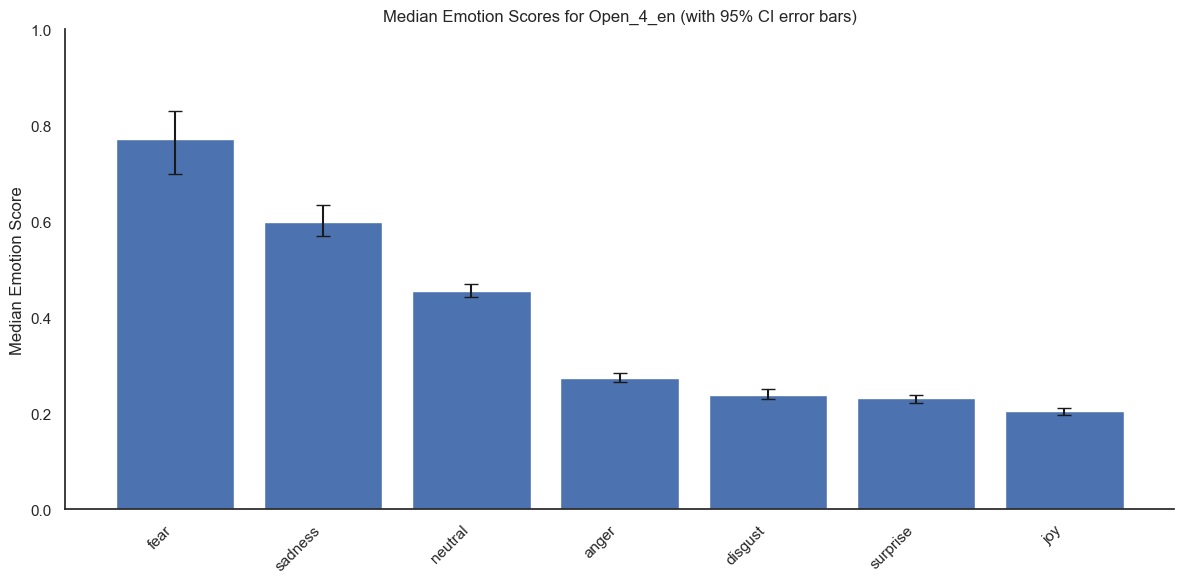

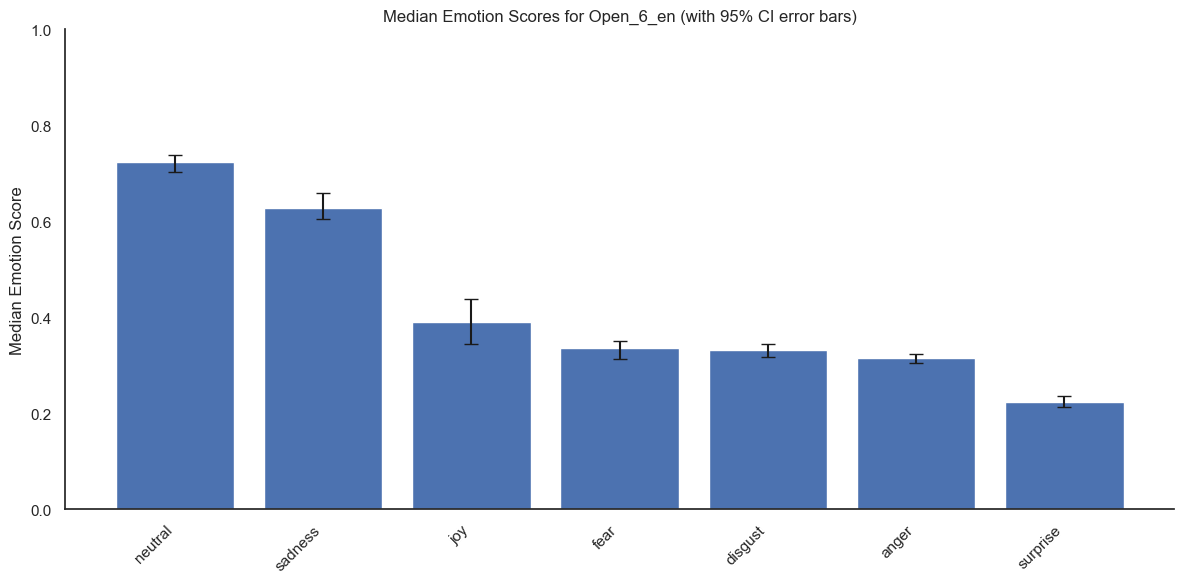

In [55]:
import matplotlib.pyplot as plt
import numpy as np

questions = [
    "Norm_Q", 
    "Open_1_en", 
    "Open_4_en",  
    "Open_6_en"
]

def bootstrap_ci(data, n_bootstrap=1000, ci=95):
    """
    Compute a bootstrap 95% CI for the median of a 1D array-like object.
    """
    medians = np.array([
        np.median(np.random.choice(data, size=len(data), replace=True))
        for _ in range(n_bootstrap)
    ])
    lower = np.percentile(medians, (100 - ci) / 2)
    upper = np.percentile(medians, 100 - (100 - ci) / 2)
    return lower, upper

for question in questions:
    emotion_cols = [f"{emotion}_score_{question}" for emotion in emotion_labels]
    emotion_cols = [col for col in emotion_cols if col in df.columns]
    
    scores = df[emotion_cols]
    medians = scores.median()

    # Compute 95% bootstrap CIs
    lower_errors = []
    upper_errors = []
    for col in emotion_cols:
        data = scores[col].dropna().values
        if len(data) > 0:
            lower, upper = bootstrap_ci(data)
            lower_errors.append(medians[col] - lower)
            upper_errors.append(upper - medians[col])
        else:
            lower_errors.append(0)
            upper_errors.append(0)

    errors = np.vstack([lower_errors, upper_errors])

    # Sort by descending median
    sorted_idx = np.argsort(-medians.values)
    sorted_medians = medians.values[sorted_idx]
    sorted_errors = errors[:, sorted_idx]
    emotion_names = [col.replace(f"_score_{question}", "") for col in medians.index]
    sorted_emotion_names = np.array(emotion_names)[sorted_idx]

    plt.figure(figsize=(12, 6))
    plt.bar(sorted_emotion_names, sorted_medians, yerr=sorted_errors, capsize=5)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Median Emotion Score")
    plt.ylim(0, 1)
    plt.title(f"Median Emotion Scores for {question} (with 95% CI error bars)")
    plt.tight_layout()
    plt.show()





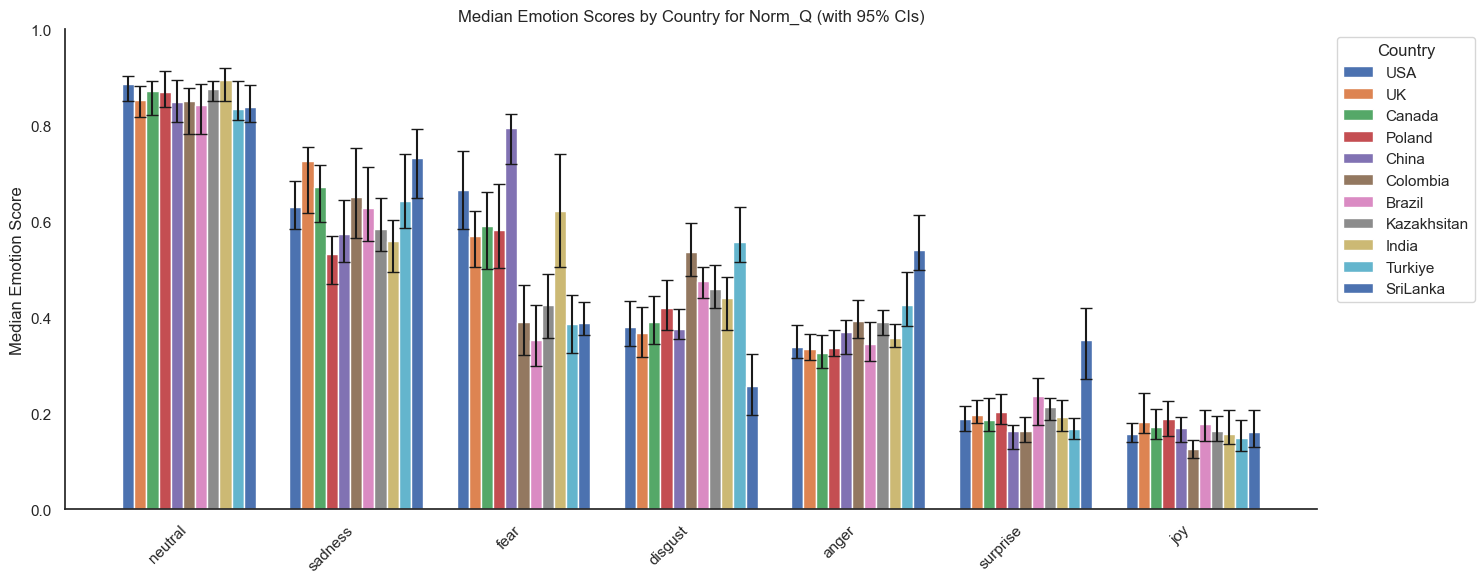

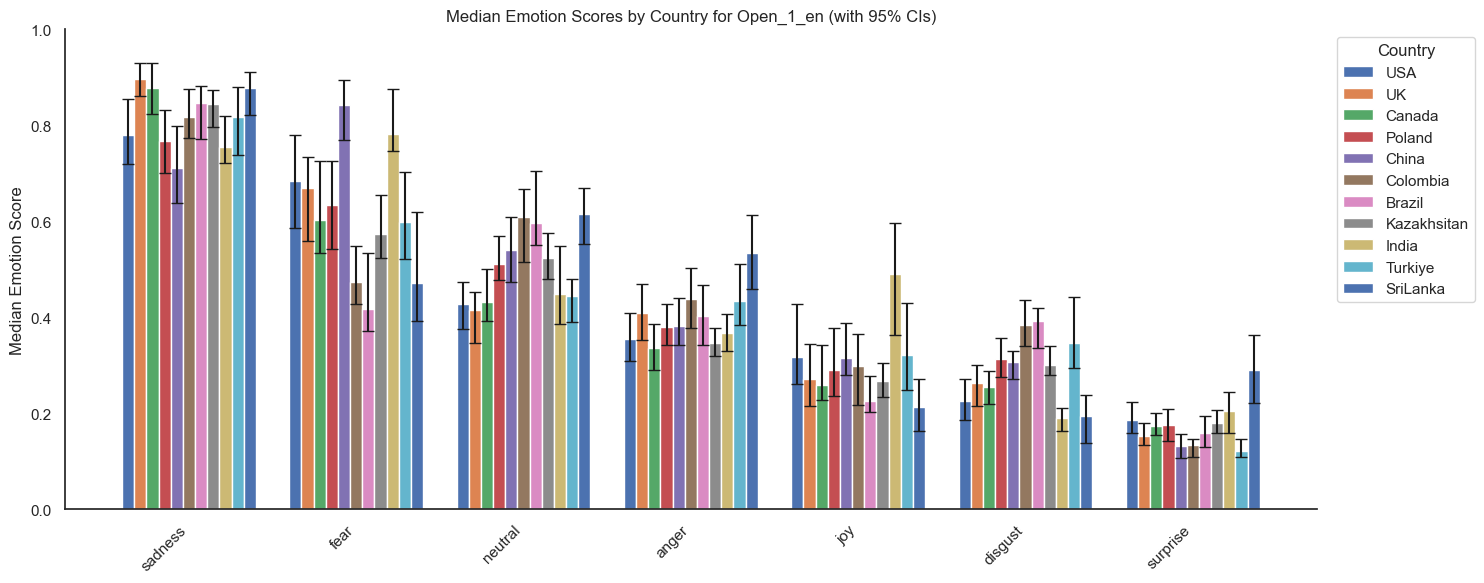

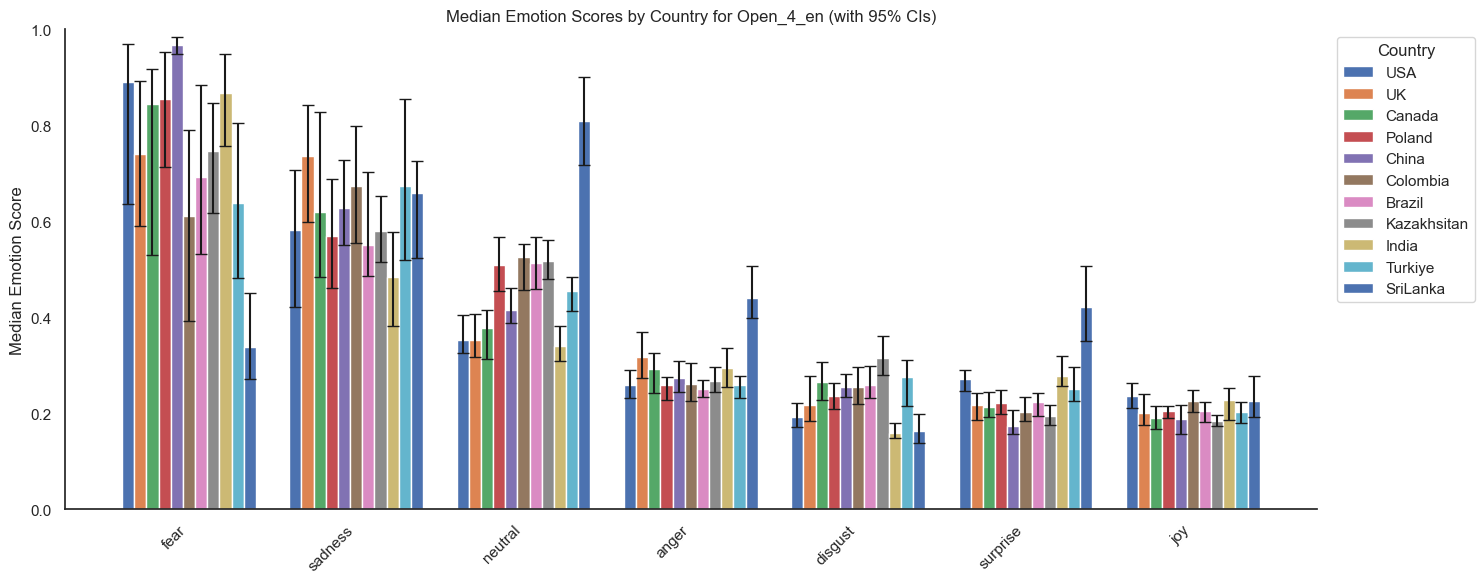

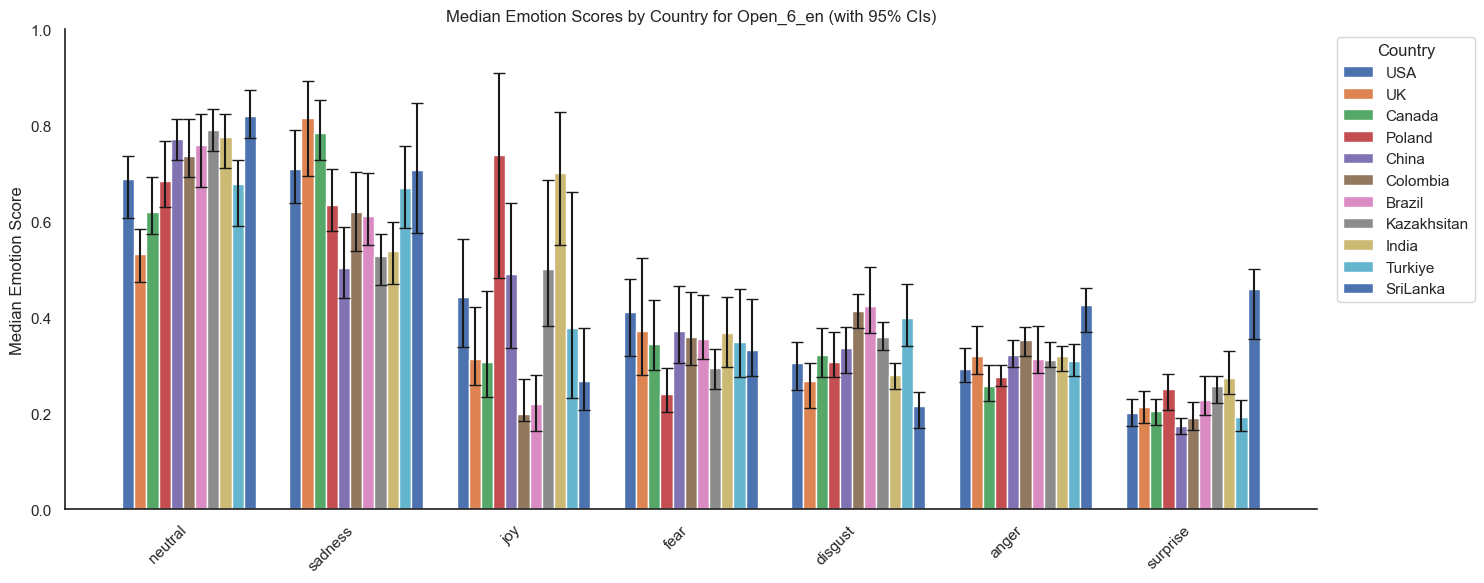

In [56]:
import matplotlib.pyplot as plt
import numpy as np

questions = [
    "Norm_Q", 
    "Open_1_en", 
    "Open_4_en",  
    "Open_6_en"
]

def bootstrap_ci(data, n_bootstrap=1000, ci=95):
    """
    Compute a bootstrap CI for the median of a 1D array.
    """
    if len(data) == 0:
        return np.nan, np.nan
    medians = np.array([
        np.median(np.random.choice(data, size=len(data), replace=True))
        for _ in range(n_bootstrap)
    ])
    lower = np.percentile(medians, (100 - ci) / 2)
    upper = np.percentile(medians, 100 - (100 - ci) / 2)
    return lower, upper

countries = df['Country'].dropna().unique()

for question in questions:
    emotion_cols = [f"{emotion}_score_{question}" for emotion in emotion_labels]
    emotion_cols = [col for col in emotion_cols if col in df.columns]
    emotion_names = [col.replace(f"_score_{question}", "") for col in emotion_cols]
    
    # For sorting: global medians
    global_medians = df[emotion_cols].median().values
    order = np.argsort(-global_medians)
    emotion_cols = [emotion_cols[i] for i in order]
    emotion_names = [emotion_names[i] for i in order]

    x = np.arange(len(emotion_cols))
    width = 0.8 / len(countries)

    plt.figure(figsize=(15, 6))
    for idx, country in enumerate(countries):
        country_df = df[df['Country'] == country]
        country_medians = []
        lower_errors = []
        upper_errors = []

        for col in emotion_cols:
            data = country_df[col].dropna().values
            if len(data) > 0:
                median_val = np.median(data)
                lower, upper = bootstrap_ci(data)
                lower_error = median_val - lower
                upper_error = upper - median_val
            else:
                median_val = np.nan
                lower_error = 0
                upper_error = 0

            country_medians.append(median_val)
            lower_errors.append(lower_error)
            upper_errors.append(upper_error)

        country_medians = np.array(country_medians)
        errs = np.vstack([lower_errors, upper_errors])

        plt.bar(
            x + idx * width,
            country_medians,
            width=width,
            yerr=errs,
            capsize=4,
            label=str(country),
            align='center'
        )

    plt.xticks(x + width * (len(countries) - 1) / 2, emotion_names, rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.ylabel("Median Emotion Score")
    plt.title(f"Median Emotion Scores by Country for {question} (with 95% CIs)")
    plt.legend(title='Country', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [ ]:
# Produces a new variable for each text variable, prepended by one of the following emotion strings:
# admiration_score_      (e.g., admiration_score_all_open)
# amusement_score_       (e.g., amusement_score_all_open)
# anger_score_           (e.g., anger_score_all_open)
# annoyance_score_       (e.g., annoyance_score_all_open)
# approval_score_        (e.g., approval_score_all_open)
# caring_score_          (e.g., caring_score_all_open)
# confusion_score_       (e.g., confusion_score_all_open)
# curiosity_score_       (e.g., curiosity_score_all_open)
# desire_score_          (e.g., desire_score_all_open)
# disappointment_score_  (e.g., disappointment_score_all_open)
# disapproval_score_     (e.g., disapproval_score_all_open)
# disgust_score_         (e.g., disgust_score_all_open)
# embarrassment_score_   (e.g., embarrassment_score_all_open)
# excitement_score_      (e.g., excitement_score_all_open)
# fear_score_            (e.g., fear_score_all_open)
# gratitude_score_       (e.g., gratitude_score_all_open)
# grief_score_           (e.g., grief_score_all_open)
# joy_score_             (e.g., joy_score_all_open)
# love_score_            (e.g., love_score_all_open)
# nervousness_score_     (e.g., nervousness_score_all_open)
# optimism_score_        (e.g., optimism_score_all_open)
# pride_score_           (e.g., pride_score_all_open)
# realization_score_     (e.g., realization_score_all_open)
# relief_score_          (e.g., relief_score_all_open)
# remorse_score_         (e.g., remorse_score_all_open)
# sadness_score_         (e.g., sadness_score_all_open)
# surprise_score_        (e.g., surprise_score_all_open)
# neutral_score_         (e.g., neutral_score_all_open)
#
# That is, for each text variable, 28 new variables are created, each corresponding to the model's predicted probability for one emotion.
# There are also versions of each of these variables ending with "_scaled" which have been logit transformed

# Traditional Linguistic Features

In [63]:
# Traditional Linguistic Feature Extraction
import pandas as pd
import re
from collections import Counter

# simple sentence splitter: splits on [.!?] plus whitespace
def split_sentences(text):
    text = text.strip()
    if not text:
        return []
    # keep the delimiter with lookbehind, then split on spaces
    return re.split(r'(?<=[\.!?])\s+', text)

# simple word tokenizer: sequences of alphabetic characters (allowing internal apostrophes)
def split_words(text):
    # this will match words like "decision", "you're", "can't"
    return re.findall(r"[A-Za-z]+(?:'[A-Za-z]+)?", text)

# compute all seven features
def compute_text_features(text):
    if not isinstance(text, str) or not text.strip():
        return (0, 0, 0.0, 0.0, 0, 0.0, 0)
    
    sents = split_sentences(text)
    words = split_words(text)
    
    nsent   = len(sents)
    nwords  = len(words)
    nchars  = len(text)
    avg_wl  = sum(len(w) for w in words) / nwords if nwords else 0.0
    avg_wps = nwords / nsent       if nsent  else 0.0
    
    freqs   = Counter(words)
    ttr     = len(freqs) / nwords if nwords else 0.0
    hapax   = sum(1 for cnt in freqs.values() if cnt == 1)
    
    return (nsent, nwords, avg_wl, avg_wps, nchars, ttr, hapax)

# the columns you care about
text_vars = [
    "Norm_Q", "Open_1_en","Open_2_en","Open_3_en","Open_4_en",
    "Open_5_en","Open_6_en","Open_7_en"
]

# prompts to strip from the merged fields
all_prompts = [
    "1. What was this difficult decision about? Please describe in detail who was involved, where and when it took place, and what was happening at that time.",
    "2. What specific issues did you encounter when making this difficult decision?",
    "3. What were you thinking when you first encountered this difficult decision?",
    "4. What were you feeling when you first encountered this difficult decision?",
    "5. If you are comfortable sharing, what steps did you take to address this difficult decision?",
    "6. In what ways did this difficult decision affect your life?",
    "7. Is there anything else you would like to share about this difficult decision?",
    "No response."
]
prompt_regex = re.compile("|".join(re.escape(p) for p in all_prompts))

# apply feature extraction
for var in text_vars:
    series = df[var].astype(str)
    feats = series.apply(compute_text_features)
    df[f"{var}_nsente"]            = feats.apply(lambda x: x[0])
    df[f"{var}_nwords"]            = feats.apply(lambda x: x[1])
    df[f"{var}_avg_word_len"]      = feats.apply(lambda x: x[2])
    df[f"{var}_avg_word_per_sent"] = feats.apply(lambda x: x[3])
    df[f"{var}_nchars"]            = feats.apply(lambda x: x[4])
    df[f"{var}_ttr"]               = feats.apply(lambda x: x[5])
    df[f"{var}_hapax"]             = feats.apply(lambda x: x[6])

# pull out only the new feature columns for a quick sanity check
feature_cols = [c for c in df.columns 
                if any(tv in c for tv in text_vars) and c not in text_vars]

temp_df = df[feature_cols]
print(temp_df.head())

                                     Norm_Q_original  \
0  Struggles with balancing potential student deb...   
1  leaving family behind and moving to another co...   
2                                            Nothing   
3  I think its whether to get married or not bein...   
4  The decision about the age at which to retire,...   

   negative_score_Norm_Q_original  neutral_score_Norm_Q_original  \
0                        0.450171                       0.510123   
1                        0.237008                       0.704092   
2                        0.342294                       0.442177   
3                        0.891650                       0.094459   
4                        0.152613                       0.731537   

   positive_score_Norm_Q_original  negative_score_Norm_Q_original_scaled  \
0                        0.039706                              -0.199981   
1                        0.058899                              -1.169151   
2                        0

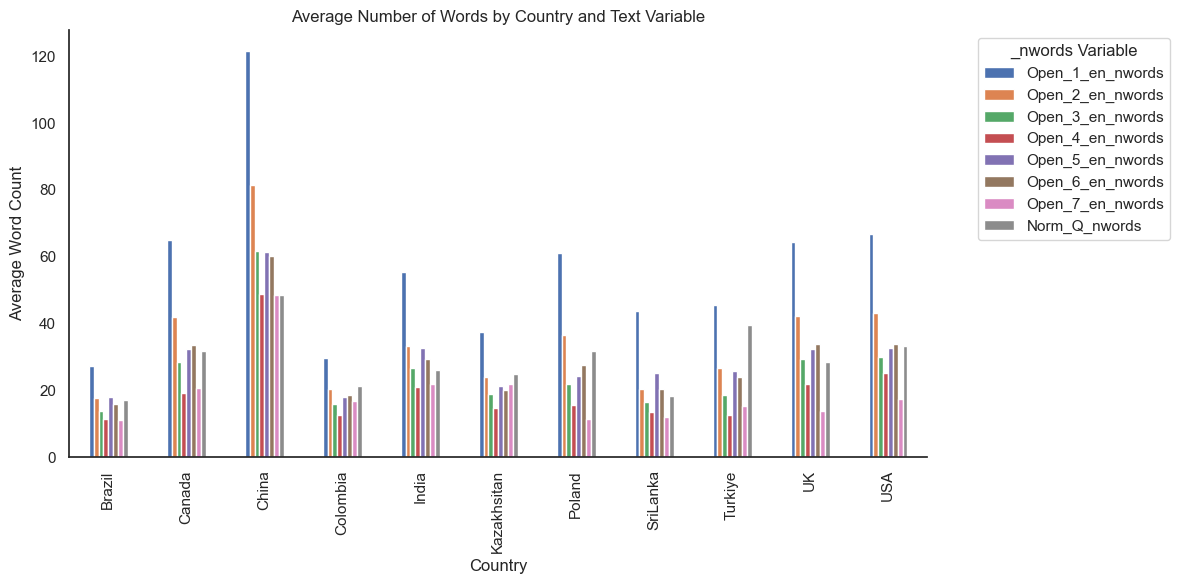

In [61]:
import matplotlib.pyplot as plt

# Extract columns ending in "_nwords"
nwords_cols = [col for col in df.columns if col.endswith("_nwords")]

# Group by Country and compute mean for each _nwords variable
grouped_means = df.groupby("Country")[nwords_cols].mean()

# Create bar plot
grouped_means.plot(kind="bar", figsize=(12, 6))
plt.ylabel("Average Word Count")
plt.title("Average Number of Words by Country and Text Variable")
plt.legend(title="_nwords Variable", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


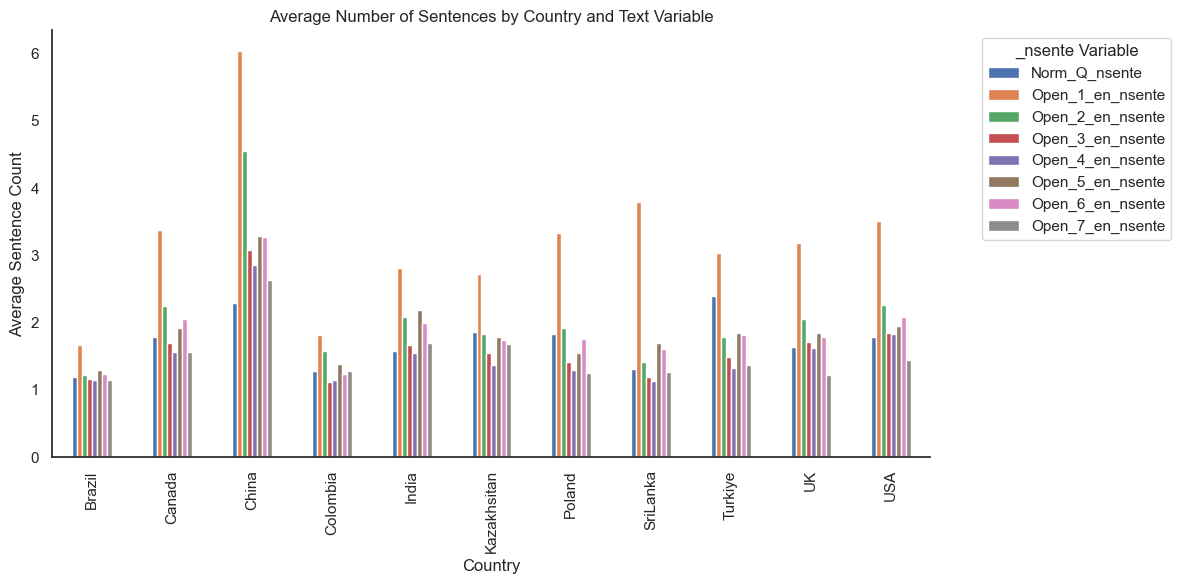

In [65]:
import matplotlib.pyplot as plt

# Extract columns ending in "_nsente"
nsente_cols = [col for col in df.columns if col.endswith("_nsente")]

# Group by Country and compute mean for each _nsente variable
grouped_nsente = df.groupby("Country")[nsente_cols].mean()

# Create bar plot
grouped_nsente.plot(kind="bar", figsize=(12, 6))
plt.ylabel("Average Sentence Count")
plt.title("Average Number of Sentences by Country and Text Variable")
plt.legend(title="_nsente Variable", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


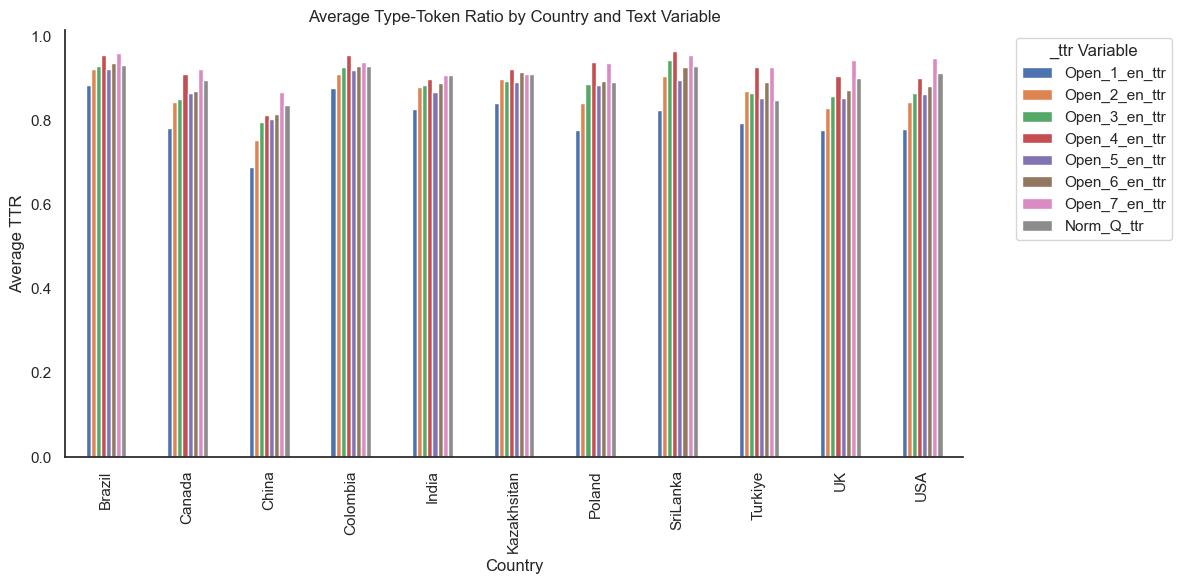

In [66]:
import matplotlib.pyplot as plt

# Extract columns ending in "_ttr"
ttr_cols = [col for col in df.columns if col.endswith("_ttr")]

# Group by Country and compute mean for each _ttr variable
grouped_ttr = df.groupby("Country")[ttr_cols].mean()

# Create bar plot
grouped_ttr.plot(kind="bar", figsize=(12, 6))
plt.ylabel("Average TTR")
plt.title("Average Type-Token Ratio by Country and Text Variable")
plt.legend(title="_ttr Variable", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [71]:
# Define feature suffixes
feature_suffixes = [
    "_nsente", "_nwords", "_avg_word_len",
    "_avg_word_per_sent", "_nchars", "_ttr", "_hapax"
]

# Identify original text variables
text_vars = [
    "Norm_Q", "Open_1_en", "Open_2_en", "Open_3_en",
    "Open_4_en", "Open_5_en", "Open_6_en", "Open_7_en"
]

# Loop through each variable and print summary table
for var in text_vars:
    feature_cols = [f"{var}{suffix}" for suffix in feature_suffixes]
    stats = pd.DataFrame({
        "mean": df[feature_cols].mean(),
        "median": df[feature_cols].median(),
        "std": df[feature_cols].std()
    }).round(3)
    
    print(f"\nDescriptive statistics for {var}:\n")
    print(stats)





Descriptive statistics for Norm_Q:

                             mean   median      std
Norm_Q_nsente               1.750    1.000    1.331
Norm_Q_nwords              29.126   20.000   29.110
Norm_Q_avg_word_len         4.738    4.600    1.247
Norm_Q_avg_word_per_sent   16.066   14.500   10.762
Norm_Q_nchars             166.130  113.000  168.777
Norm_Q_ttr                  0.900    0.917    0.105
Norm_Q_hapax               20.458   17.000   15.586

Descriptive statistics for Open_1_en:

                                mean   median      std
Open_1_en_nsente               3.152    2.000    2.762
Open_1_en_nwords              55.056   42.000   59.711
Open_1_en_avg_word_len         4.357    4.250    1.236
Open_1_en_avg_word_per_sent   18.034   16.000   11.273
Open_1_en_nchars             298.118  222.000  341.916
Open_1_en_ttr                  0.808    0.805    0.125
Open_1_en_hapax               31.178   27.000   23.471

Descriptive statistics for Open_2_en:

                           

# Cosine Similarity Analyses

In [25]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# 1. Load model
model = SentenceTransformer('sentence-transformers/stsb-xlm-r-multilingual')

# 2. Extract texts (ensure no NaNs)
texts_3 = df['Open_3_original'].fillna('').astype(str).tolist()
texts_4 = df['Open_4_original'].fillna('').astype(str).tolist()
texts_5 = df['Open_5_original'].fillna('').astype(str).tolist()

# 3. Compute embeddings (adjust batch_size as needed)
emb_3 = model.encode(texts_3, batch_size=32, show_progress_bar=True)
emb_4 = model.encode(texts_4, batch_size=32, show_progress_bar=True)
emb_5 = model.encode(texts_5, batch_size=32, show_progress_bar=True)

# 4. Define a helper for row-wise cosine
def row_cosine(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    norm_a = np.linalg.norm(a, axis=1)
    norm_b = np.linalg.norm(b, axis=1)
    dot    = np.sum(a * b, axis=1)
    return dot / (norm_a * norm_b + 1e-10)  # small eps to avoid div0

# 5. Compute similarities and assign to new columns
df['sim_open3_open4'] = row_cosine(emb_3, emb_4)
df['sim_open3_open5'] = row_cosine(emb_3, emb_5)
df['sim_open4_open5'] = row_cosine(emb_4, emb_5)

# Replace perfect similarity scores with NaN
similarity_cols = ['sim_open3_open4', 'sim_open3_open5', 'sim_open4_open5']
for col in similarity_cols:
    df[col] = df[col].mask(df[col] == 1.0, np.nan)

# Inspect
print(df[['sim_open3_open4','sim_open3_open5','sim_open4_open5']].head())

Batches: 100%|██████████| 57/57 [00:12<00:00,  4.57it/s]

   sim_open3_open4  sim_open3_open5  sim_open4_open5
0         0.726915         0.342492         0.398114
1         0.456720         0.458509         0.275434
2         0.674828         0.365791         0.326050
3         0.544468         0.245308         0.356330
4         0.150348         0.078774         0.010221


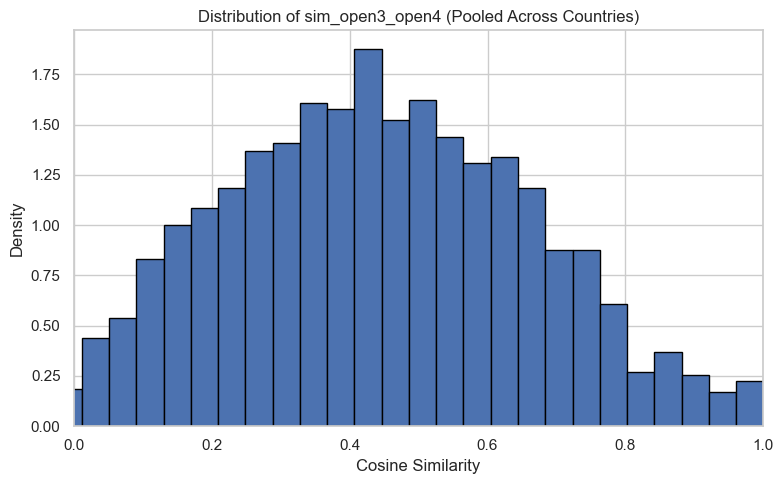

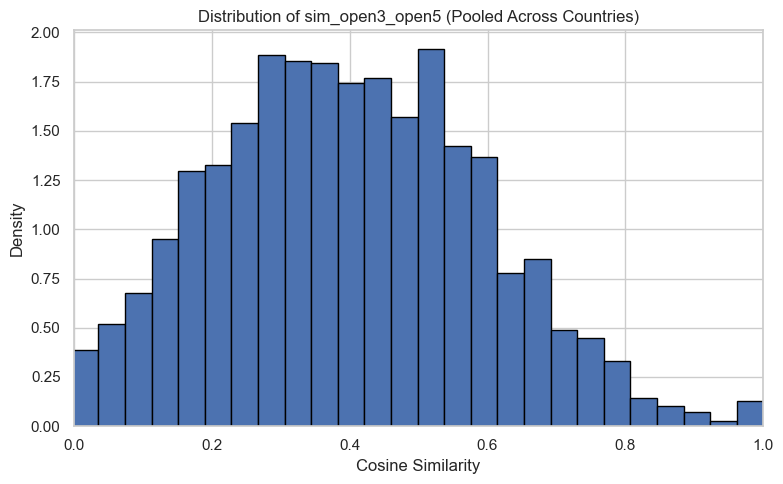

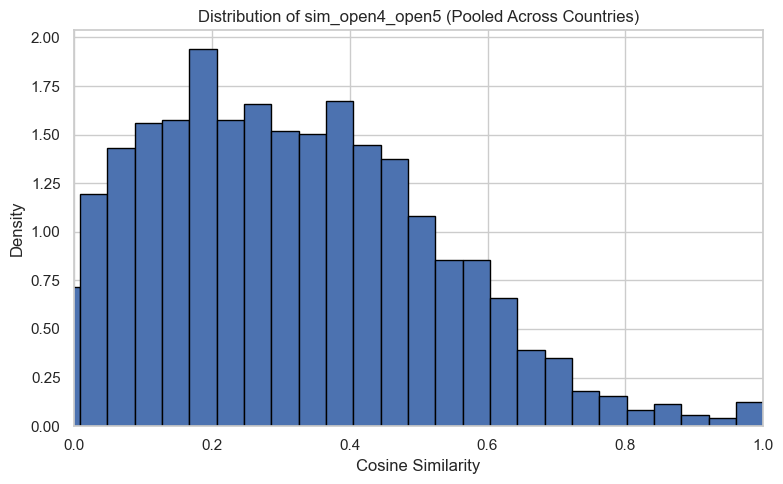

In [26]:
import seaborn as sns

# Ensure seaborn is set for better aesthetics (optional)
sns.set(style="whitegrid")

# Plot a separate histogram for each similarity feature across all countries
for col in ['sim_open3_open4', 'sim_open3_open5', 'sim_open4_open5']:
    plt.figure(figsize=(8, 5))
    plt.hist(df[col].dropna(), bins=30, density=True, edgecolor='black')
    plt.title(f'Distribution of {col} (Pooled Across Countries)')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Density')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

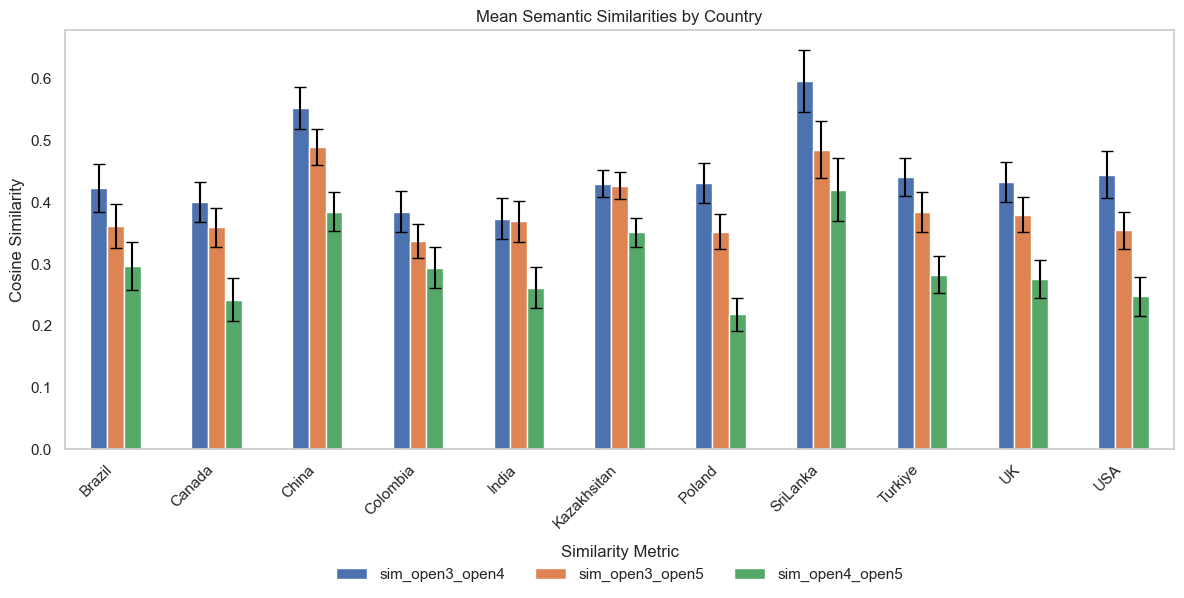

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Compute country-wise means and 95% confidence intervals
grouped = df.groupby('Country')[['sim_open3_open4', 'sim_open3_open5', 'sim_open4_open5']]
country_means = grouped.mean()
country_counts = grouped.count()
country_stds = grouped.std()

# Compute standard errors
country_sems = country_stds / np.sqrt(country_counts)

# Approximate 95% CI (z ≈ 1.96 for large n)
country_cis = country_sems * 1.96

# 2. Sort index for consistent ordering
country_means = country_means.sort_index()
country_cis = country_cis.loc[country_means.index]  # align order

# 3. Plot with 95% CI error bars
ax = country_means.plot(
    kind='bar',
    figsize=(12, 6),
    yerr=country_cis,
    capsize=4,
    ecolor='black'
)

# 4. Aesthetics
ax.grid(False)  # remove background grid
plt.title('Mean Semantic Similarities by Country')
plt.ylabel('Cosine Similarity')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')

# Adjust layout to avoid overlap
plt.subplots_adjust(bottom=0.25)

# Reposition legend above plot instead of below to avoid x-label overlap
ax.legend(
    title='Similarity Metric',
    loc='lower center',
    bbox_to_anchor=(0.5, -0.35),
    ncol=3,
    frameon=False
)

plt.tight_layout()
plt.show()


# Multilingual Topic Model

In [ ]:
# Embed text
from sentence_transformers import SentenceTransformer
import numpy as np
import os

def compute_and_save_embeddings(df, column_name, output_path, model=None, batch_size=32):
    if model is None:
        model = SentenceTransformer('sentence-transformers/stsb-xlm-r-multilingual')
    
    texts = df[column_name].fillna('').astype(str).tolist()
    embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=True)
    np.save(output_path, embeddings)

# Load model once
model = SentenceTransformer('sentence-transformers/stsb-xlm-r-multilingual')

# List of target columns
target_columns = ['Open_Q1_2_original']
    #'Norm_Q_original', 'Open_1_original', 'Open_2_original', 'Open_3_original', 
    #'Open_4_original', 'Open_5_original', 'Open_6_original', 'Open_7_original', 
    #'all_open_original', 'Open_Q1_2_original', 'Open_Q3_4_original']

# Base output directory
output_dir = '/Users/willjettinghoff/Desktop/Wise Jugement/Embeddings/Wave 1/'

# Batch processing
for col in target_columns:
    output_path = os.path.join(output_dir, f'emb_{col}.npy')
    compute_and_save_embeddings(df, col, output_path, model=model, batch_size=32)

/Users/willjettinghoff/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 57/57 [00:20<00:00,  2.73it/s]


/Users/willjettinghoff/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/willjettinghoff/.pyenv/versions/3.11.9/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/willjettinghoff/.pyenv/versions/3.11.9/lib/python3.11/site-packages/umap/plot.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

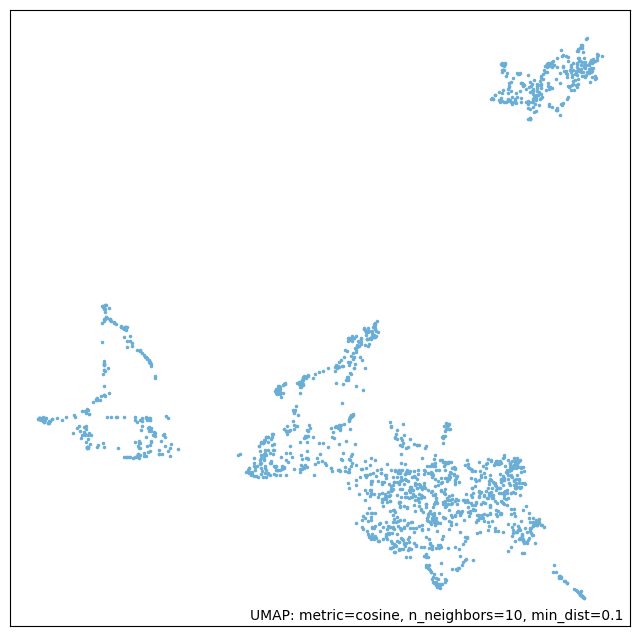

In [5]:
# Plot on 2D with UMAP
# Load precomputed embeddings
import numpy as np

# from 'Norm_Q_original'
#emb_Norm_Q_original = np.load('/Users/willjettinghoff/Desktop/Wise Jugement/Embeddings/Wave 1/emb_Norm_Q_original.npy')

# from 'Open_1_original'
#emb_Open_1_original = np.load('/Users/willjettinghoff/Desktop/Wise Jugement/Embeddings/Wave 1/emb_Open_1_original.npy')

# from 'Open_2_original'
# emb_Open_2_original = np.load('/Users/willjettinghoff/Desktop/Wise Jugement/Embeddings/Wave 1/emb_Open_2_original.npy')

# from 'Open_3_original'
# emb_Open_3_original = np.load('/Users/willjettinghoff/Desktop/Wise Jugement/Embeddings/Wave 1/emb_Open_3_original.npy')

# from 'Open_4_original'
# emb_Open_4_original = np.load('/Users/willjettinghoff/Desktop/Wise Jugement/Embeddings/Wave 1/emb_Open_4_original.npy')

# from 'Open_5_original'
# emb_Open_5_original = np.load('/Users/willjettinghoff/Desktop/Wise Jugement/Embeddings/Wave 1/emb_Open_5_original.npy')

# from 'Open_6_original'
# emb_Open_6_original = np.load('/Users/willjettinghoff/Desktop/Wise Jugement/Embeddings/Wave 1/emb_Open_6_original.npy')

# from 'Open_7_original'
# emb_Open_7_original = np.load('/Users/willjettinghoff/Desktop/Wise Jugement/Embeddings/Wave 1/emb_Open_7_original.npy')

# from 'all_open_original'
# emb_all_open_original = np.load('/Users/willjettinghoff/Desktop/Wise Jugement/Embeddings/Wave 1/emb_all_open_original.npy')

# from 'Open_Q1_2_original'
emb_Open_Q1_2_original = np.load('/Users/willjettinghoff/Desktop/Wise Jugement/Embeddings/Wave 1/emb_Open_Q1_2_original.npy')

# from 'Open_Q3_4_original'
# emb_Open_Q3_4_original = np.load('/Users/willjettinghoff/Desktop/Wise Jugement/Embeddings/Wave 1/emb_Open_Q3_4_original.npy')

# from 'Open_Q1234_original'
# emb_Open_Q1234_original = np.load('/Users/willjettinghoff/Desktop/Wise Jugement/Embeddings/Wave 1/emb_Open_Q1234_original.npy')

import umap
import umap.plot

emb_Open_Q1_2_original_2d = umap.UMAP(
    n_components=2,
    n_neighbors=10,
    metric='cosine',
    min_dist=0.1,
    random_state=12345).fit(emb_Open_Q1_2_original)

umap.plot.points(emb_Open_Q1_2_original_2d)

/Users/willjettinghoff/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/willjettinghoff/.pyenv/versions/3.11.9/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


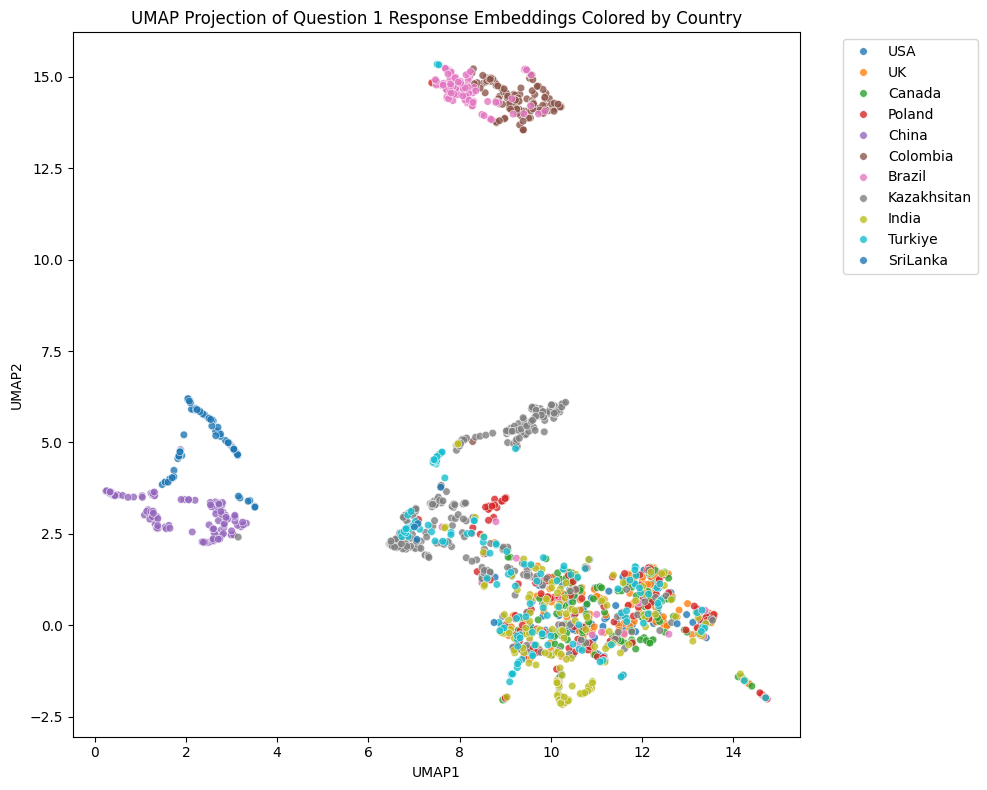

In [ ]:
# Color points by country
import umap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# UMAP dimensionality reduction
reducer = umap.UMAP(
    n_components=2, # ()
    n_neighbors=10, # local and global structure ()
    metric='cosine',
    min_dist=0.01,
    random_state=12345
)

embed_2d = reducer.fit_transform(emb_Open_Q1_2_original)

# Create a DataFrame for plotting
plot_df = pd.DataFrame(embed_2d, columns=['UMAP1', 'UMAP2'])
plot_df['Country'] = df['Country'].values

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=plot_df, x='UMAP1', y='UMAP2', hue='Country', palette='tab10', s=30, alpha=0.8)
plt.title('UMAP Projection of Question 1 Response Embeddings Colored by Country')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Define the topic modeling pipeline
import tiktoken
import openai
import numpy as np
import torch

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance

from sentence_transformers import SentenceTransformer
import umap
import hdbscan

# Set reproducibility seed
seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)

# UMAP dimensionality reduction
umap_model = umap.UMAP(
    n_components=6,
    n_neighbors=15,
    metric='cosine',
    min_dist=0.1,
    random_state=seed
)

# HDBSCAN clustering
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    cluster_selection_method='leaf',
    approx_min_span_tree=False,
    prediction_data=True
)

# Vectorizer and transformation model
vectorizer = CountVectorizer(ngram_range=(2, 4), stop_words="english")
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Topic representation model
# representation_model = MaximalMarginalRelevance(diversity=0.1)
# Tokenizer
tokenizer= tiktoken.encoding_for_model("gpt-4o")

# Create your representation model
client = openai.OpenAI(api_key="<your_key>")

from bertopic.representation import PartOfSpeech
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import KeyBERTInspired
from bertopic.representation import OpenAI
import openai

prompt = """You will extract a short topic label from given documents and keywords. 
All documents are about difficult life decisions, therefore your goal is to determine a representative and distinctive label for the documents and keywords within the context of difficult life decisions.
Here are two examples of topics you created before:

# Example 1
Sample texts from this topic:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the worst food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

Keywords: meat beef eat eating emissions steak food health processed chicken
topic: Environmental impacts of eating meat

# Example 2
Sample texts from this topic:
- I have ordered the product weeks ago but it still has not arrived!
- The website mentions that it only takes a couple of days to deliver but I still have not received mine.
- I got a message stating that I received the monitor but that is not true!
- It took a month longer to deliver than was advised...

Keywords: deliver weeks product shipping long delivery received arrived arrive week
topic: Shipping and delivery issues

# Your task
Sample texts from this topic:
[DOCUMENTS]

Keywords: [KEYWORDS]

Based on the information above, extract a short topic label (three words at most) in the following format:
topic: <topic_label>"""

gpt = OpenAI(
    client,
    model="gpt-4o",
    delay_in_seconds=3,
    chat=True,
    nr_docs=5,
    doc_length=512,
    tokenizer=tokenizer,
    prompt=prompt
)

mmr = MaximalMarginalRelevance(diversity=.5)
keybertins = KeyBERTInspired(top_n_words=20)

# Add all models together to be run in a single `fit`
representation_models = {
    # "keybertins":  keybertins,
    "mmr":  mmr,
    "gpt":  gpt,
}


# Define BERTopic model
topic_model = BERTopic(
    vectorizer_model=vectorizer,
    ctfidf_model=ctfidf_model,
    representation_model=representation_models,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    top_n_words=10,
    calculate_probabilities=True,
    verbose=True
)

In [ ]:
# Apply topic modeling pipeline
import pandas as pd
import numpy as np

# docs = df['all_open_en'].astype(str)
docs = df['Open_Q1_2_en'].astype(str)

# Fit the BERTopic model to the documents and embeddings
topics, probabilities = topic_model.fit_transform(docs, emb_Open_Q1_2_original) # emb_all_qs_original, emb_Q1_original

# Extract topic-term tf-idf matrix
topic_term_matrix = topic_model.c_tf_idf_

# Construct DataFrame with topic probabilities per document
df_probabilities = pd.DataFrame(probabilities, columns=[f"Topic_{i}" for i in range(probabilities.shape[1])])

# Combine with original comment-level metadata
df = pd.concat([df, df_probabilities], axis=1)

# Optionally save outputs
# df_combined.to_csv("/path/to/output/topic_probabilities.csv", index=False)
# topic_model.save("/path/to/output/bertopic_model", serialization="safetensors", save_ctfidf=True)

# To load a previously saved model
# topic_model = BERTopic.load("/path/to/output/bertopic_model")

2025-06-23 22:52:15,597 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-23 22:52:19,099 - BERTopic - Dimensionality - Completed ✓
2025-06-23 22:52:19,100 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-23 22:52:19,177 - BERTopic - Cluster - Completed ✓
2025-06-23 22:52:19,178 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 33/33 [02:05<00:00,  3.80s/it]
2025-06-23 22:54:25,165 - BERTopic - Representation - Completed ✓


In [ ]:
import umap

# docs = df['all_open_en'].astype(str)
docs = df['Open_Q1_2_en'].astype(str)

topic_model.visualize_barchart(
    custom_labels=False, # ignored if none provided
    autoscale=True,
    top_n_topics=100, # arbitrarily high number to make sure all are plotted
    n_words=10,
    width=250, # def = 250
    height=500,
    title="Top 10 phrases per topic"
    )

In [ ]:
embed_2d = umap.UMAP(
    n_components=2,
    n_neighbors=10,
    metric='cosine',
    min_dist=0.01,
    random_state=12345).fit_transform(emb_Open_Q1_2_original)

topic_model.visualize_documents(docs, reduced_embeddings=embed_2d,
                                hide_annotations=True, custom_labels=True,
                                width=1400, height=800)

In [ ]:
import bertopic

# produce a table where each row is a topic, and each columns records metadata about the topic, like the top phrases, 3 most representative comments, number of comments per topic, etc.
topic_model_summary = topic_model.get_topic_info()

# Function to unnest lists in the Representative_Docs column, placing each comment in its own column
def unnest_comments(row):
    comments = ast.literal_eval(row['Representative_Docs']) if isinstance(row['Representative_Docs'], str) else row['Representative_Docs']
    for i, comment in enumerate(comments):
        row[f'comment_{i+1}'] = comment
    return row

# Apply the function to each row in the dataframe
unnested_topic_model_summary = topic_model_summary.apply(unnest_comments, axis=1)

# Drop the original Representative_Docs column
unnested_topic_model_summary = unnested_topic_model_summary.drop(columns=['Representative_Docs'])

gpt_list = unnested_topic_model_summary['gpt'].tolist()
for item in gpt_list:
    print(item)
    
# Display the result
unnested_topic_model_summary

['Personal Life Choices']
['Education and Career Choices']
['Life-changing Challenges']
['Life-Altering Decisions']
['Major Life Transitions']
['Career vs. Personal Life']
['Career Transition Challenges']
['Financial Dilemmas']
['Pet Care Decisions']
['Complex Personal Choices']
['Career vs. Stability']
['Ending Relationships']
['Life-Changing Decisions']
['Career Decision-Making']
['Personal Life Decisions']
['Major Life Transitions']
['Job Relocation Dilemma']
['Crossroads in Life']
['Personal Life Decisions']
['MBA Program Decisions']
['Career and Relationships Dilemmas']
['Major Life Transitions']
['Navigating Life Changes']
['Major Financial Decisions']
['Marriage Decision Challenges']
['Financial Decision-Making']
['Personal Medical Decisions']
['Major Life Transitions']
['Health and Relocation Decisions']
['Medical Treatment Decisions']
['Career Transition Challenges']
['Career Change Decisions']
['Relocation and Independence']


Topic  Count                                               Name  \
0      -1    822  -1_took place_involved took place_involved too...   
1       0     91  0_masters degree_continue education_high schoo...   
2       1     88  1_making difficult decision_making difficult_e...   
3       2     86  2_decision involved_specific issues did encoun...   
4       3     80  3_decision question_difficult decision questio...   
5       4     48  4_entrance examination_years old_career develo...   
6       5     42  5_current job_leave current job_happening time...   
7       6     39  6_better paying job_better paying_paying job_n...   
8       7     37  7_dog sleep_year old_veterinary clinic_respons...   
9       8     31  8_perform surgery_family member house_technolo...   
10      9     30  9_career development_stable job_people involve...   
11     10     29  10_mutual friends_cut ties_decision end_end re...   
12     11     26  11_masters thesis_private school_happening tim...   
13     12     26  12_entrance examination_postgraduate entrance_...   
14     13     25  13_happening time sending_time sending_place h...   
15     14     25  14_xa specific_xa specific issues_xa specific ...   
16     15     24   15_new city_new job_different city_city decision   
17     16     23  16_place study department_look child_best plac...   
18     17     21  17_country specific issues_country specific is...   
19     18     21  18_pursue mba_mba college_college mba_pursuing...   
20     19     20  19_like ive make_like ive_dont feel_dont feel ...   
21     20     19  20_photo studio_march year_studying abroad_col...   
22     21     17  21_place happening time xmlspacepreservei_time...   
23     22     16    22_new car_car wanted_buying new car_buying new   
24     23     16  23_wanted marry_loss mother_entering new relat...   
25     24     16  24_computer science poland_make living streami...   
26     25     16  25_decision father_admitted hospital_said vent...   
27     26     14  26_place happening time financial_happening ti...   
28     27     14  27_time xmlspacepreservehaving_happening time ...   
29     28     12  28_decision undergo_effective consistent_chemo...   
30     29     11  29_corporate job_emotional pressure_pressure f...   
31     30     11  30_new manager_employment lawyer_months changi...   
32     31     10  31_miles away_sisters house_150 miles_mother s...   

                                       Representation  \
0   [took place, involved took place, involved too...   
1   [masters degree, continue education, high scho...   
2   [making difficult decision, making difficult, ...   
3   [decision involved, specific issues did encoun...   
4   [decision question, difficult decision questio...   
5   [entrance examination, years old, career devel...   
6   [current job, leave current job, happening tim...   
7   [better paying job, better paying, paying job,...   
8   [dog sleep, year old, veterinary clinic, respo...   
9   [perform surgery, family member house, technol...   
10  [career development, stable job, people involv...   
11  [mutual friends, cut ties, decision end, end r...   
12  [masters thesis, private school, happening tim...   
13  [entrance examination, postgraduate entrance, ...   
14  [happening time sending, time sending, place h...   
15  [xa specific, xa specific issues, xa specific ...   
16  [new city, new job, different city, city decis...   
17  [place study department, look child, best plac...   
18  [country specific issues, country specific iss...   
19  [pursue mba, mba college, college mba, pursuin...   
20  [like ive make, like ive, dont feel, dont feel...   
21  [photo studio, march year, studying abroad, co...   
22  [place happening time xmlspacepreservei, time ...   
23  [new car, car wanted, buying new car, buying n...   
24  [wanted marry, loss mother, entering new relat...   
25  [computer science poland, make living streamin...   
26  [decision father, admitted hospital, said vent